In [1]:
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations
import html
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
import math
from math import pi
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

sns.set(style='darkgrid', context='notebook', font_scale=2.5, rc={'figure.figsize':(14,10)})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import nltk
from nltk.metrics import agreement,masi_distance,jaccard_distance, interval_distance, binary_distance 
from nltk.metrics.agreement import AnnotationTask

from scipy.stats import mode

In [2]:
# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)

RandomState(MT19937) at 0x7F8BAC222E40

### Agreement

In [3]:
df1 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Dec_28/Batch_4640089_batch_results.csv', encoding="utf-8")        # tweets from 2010-21
df2 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Jan_4/Batch_4642353_batch_results.csv', encoding="utf-8")         # tweets from 2010-21
df = pd.concat([df1, df2])


df3 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Jan_14/Batch_4648550_batch_results.csv', encoding="utf-8")        # tweets from 2010-21
df4 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Jan_24/Batch_4655572_batch_results.csv', encoding="utf-8")        # tweets from 2010-21
df5 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Jan_24_supp/Batch_4655136_batch_results.csv', encoding="utf-8")   # Attempt to redo tweets from earlier
df6 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Feb_11/Batch_4669568_batch_results.csv', encoding="utf-8")    # 115 congress only
df7 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Feb_25/Batch_4678859_batch_results.csv', encoding="utf-8")    # 114 congress only
df8 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_Feb_28/Batch_4680576_batch_results.csv', encoding="utf-8")    # 116 congress only
df9 = pd.read_csv('../../data-annotation/annotation-tasks/Main_task_March_8/Batch_4686887_batch_results.csv', encoding="utf-8")    # 116 congress only
df_new = pd.concat([df3, df4, df5, df6, df7, df8, df9])

columns_needed = ['WorkerId', 'Input.var_arrays', 'Answer.taskAnswers', 'WorkTimeInSeconds']

# Filter out bad workers you had earlier qualified here
df = df[df['WorkerId']!='A13OHV8TPRTDB9']


In [4]:
df.shape

(200, 31)

In [5]:
df_new.shape

(2853, 31)

First convert into dataframe where each row is the annotation of a single tweet by a single worker

In [6]:
emot_ans = ['Admiration', 'Anger', 'Disgust', 'Fear', 'Interest', 'Joy', 'Sadness', 'Surprise']
behavior_ans = ['app', 'disapp', 'mixed_app', 'neut_app', 'dunno_app']
feeling_ans = ['warm', 'cold', 'mixed', 'neutral', 'dunno']
predom_ans = ['predom', 'not_predom', 'dunno_predom']

ann_df = []

def split_records(x):
    '''
    Splits each row into 3 different annotations for each tweet being annotated
    '''

    worker_id = x['WorkerId']
    questions = eval(x['Input.var_arrays'].encode('utf-8', 'replace').decode())
    answers = eval(x['Answer.taskAnswers'].encode('utf-8', 'replace').decode().replace("true", "True").replace("false", "False"))[0]
    
    for i in range(len(questions)):
        new_row = {}
        
        # Get some basic worker and question info
        new_row['WorkerId'] = worker_id
        new_row['TweetId'] = str(questions[i]['id'])
        new_row['tweet'] = html.unescape(questions[i]['tweet'].replace("<strong>&#64;Doe<\/strong>", "@" + questions[i]['mentname'])).encode('utf-8', 'replace').decode()
        new_row['mentname'] = questions[i]['mentname']
        new_row['username'] = questions[i]['username']
        new_row['date'] = questions[i]['date']
        
        # Now get answers
        for ans in predom_ans:
            if answers[ans + "_" + str(i)]["on"]:
                new_row["Predom"] = ans
        
        for ans in behavior_ans:
            if answers[ans + "_" + str(i)]["on"]:
                if ans in ['app', 'disapp']:
                    new_row["Behavior"] = ans
                elif ans == 'mixed_app':
                    new_row["Behavior"] = "mixed"
                elif ans== 'dunno_app':
                    new_row['Behavior'] = "dunno"
                else:
                    new_row['Behavior'] = "neutral"
        for ans in feeling_ans:
            if answers[ans + "_" + str(i)]["on"]:
                new_row["Feeling"] = ans
        
        # Now emotions are appended
        emot_ansi = answers['entity_emotions' + "_" + str(i)]
        new_row.update(emot_ansi)
        
        if True not in emot_ansi.values():
            new_row['No_Emotion'] = True
        else:
            new_row['No_Emotion'] = False
        
        # Now emotional intensities
        for emot in emot_ans:
            new_row[emot + "_Int"] = answers[emot + '-conf_' + str(i)] 
        
        ann_df.append(new_row)
        
       
df.apply(lambda x: split_records(x), axis=1)
len(ann_df)

600

In [7]:
emot_ans2 = ['Admiration', 'Anger', 'Disgust', 'Fear', 'Interest', 'Joy', 'Sadness', 'Surprise']
behavior_ans2 = ['app', 'disapp', 'mixed', 'neutral', 'dunno']
feeling_ans2 = ['warm', 'cold', 'mixed', 'neutral', 'dunno']
predom_ans2 = ['predom', 'not_predom', 'dunno_predom']

def split_records2(x):
    '''
    Splits each row into 3 different annotations for each tweet being annotated. This is for the new protocol
    variable names - jobs after Jan 4th.
    '''

    worker_id = x['WorkerId']
    questions = eval(x['Input.var_arrays'].encode('utf-8', 'replace').decode())
    answers = eval(x['Answer.taskAnswers'].encode('utf-8', 'replace').decode().replace("true", "True").replace("false", "False"))[0]
    
    for i in range(len(questions)):
        new_row = {}
        
        # Get some basic worker and question info
        new_row['WorkerId'] = worker_id
        new_row['TweetId'] = str(questions[i]['id'])
        new_row['tweet'] = html.unescape(questions[i]['tweet'].replace("<strong>&#64;Doe<\/strong>", "@" + questions[i]['mentname'])).encode('utf-8', 'replace').decode()
        new_row['mentname'] = questions[i]['mentname']
        new_row['username'] = questions[i]['username']
        new_row['date'] = questions[i]['date']
        
        # Now get answers
        for ans in predom_ans2:
            if answers["predom_" + str(i)][ans]:
                new_row["Predom"] = ans
        
        for ans in behavior_ans2:
            if answers["app_" + str(i)][ans]:
                new_row["Behavior"] = ans
        
        for ans in feeling_ans2:
            if answers["feel_" + str(i)][ans]:
                new_row["Feeling"] = ans
        
        # Now emotions are appended
        emot_ansi = answers['entity_emotions_' + str(i)]
        new_row.update(emot_ansi)
        
        new_row['No_Emotion'] = answers['no_emotions_' + str(i)]['None']
        
        # Now emotional intensities
        for emot in emot_ans2:
            new_row[emot + "_Int"] = answers[emot + '-conf_' + str(i)] 
        
        ann_df.append(new_row)
        
df_new.apply(lambda x: split_records2(x), axis=1)
len(ann_df)

9157

In [8]:
ann_df = pd.DataFrame(ann_df)

In [9]:
ann_df.shape

(9157, 26)

In [10]:
ann_df = ann_df.dropna()
ann_df.shape

(9153, 26)

How many annotations per tweet?

In [11]:
Counter(Counter(ann_df.TweetId.values).values())

Counter({3: 3033, 2: 27})

How many did each worker do?

In [12]:
Counter(ann_df.WorkerId.values)

Counter({'A2V66KLFVJTLKC': 2910,
         'A32W24TWSWXW': 2711,
         'A345TDMHP3DQ3G': 3057,
         'A3P9TM5PRYBH90': 469,
         'A320QA9HJFUOZO': 3,
         'A1PHTNZ62338BP': 3})

How many unique tweets?

In [13]:
len(ann_df.TweetId.unique())

3060

In [14]:
def dt_convert(x):
    if type(x) == str:
        datetime_object = datetime.strptime(x, '%Y-%m-%d')
    else:
        datetime_object = datetime.utcfromtimestamp(x/1000)           # Time is in milliseconds
    
    return datetime_object

ann_df['Date'] = ann_df['date'].apply(lambda x: dt_convert(x))
Counter([x.year for x in ann_df.Date.tolist()])

Counter({2019: 1117,
         2016: 1113,
         2021: 391,
         2013: 964,
         2017: 1312,
         2020: 1063,
         2018: 1100,
         2014: 991,
         2015: 1062,
         2012: 22,
         2011: 12,
         2010: 6})

In [15]:
## Remove tweets which have only 2 annotations
asdf = Counter(ann_df.TweetId.values)
two_ann_tweets = [a for a in asdf.keys() if asdf[a]==2]
ann_df = ann_df[~ann_df['TweetId'].isin(two_ann_tweets)]

This is the dataframe of every **annotation** unconsolidated

In [16]:
ann_df.head()

,WorkerId,TweetId,tweet,mentname,username,date,Predom,Behavior,Feeling,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise,No_Emotion,Admiration_Int,Anger_Int,Disgust_Int,Fear_Int,Interest_Int,Joy_Int,Sadness_Int,Surprise_Int,Date
0,A2V66KLFVJTLKC,1083418646926495744,MUST WATCH. @speakerpelosi to Republicans: “Did you take an oath to the Constitution or an oath to Donald Trump?” *mic drop* ??????,speakerpelosi,repdwightevans,2019-01-10,predom,app,warm,True,False,False,False,False,False,False,False,False,2,2,2,2,2,2,2,2,2019-01-10
1,A2V66KLFVJTLKC,771801026169040896,Check out highlights from the #Seed2Sawmill tour w\/ @repwesterman. We had a great time learning about #AR forestry!,repwesterman,johnboozman,2016-09-02,predom,app,warm,False,False,False,False,False,True,False,False,False,2,2,2,2,2,3,2,2,2016-09-02
2,A2V66KLFVJTLKC,1359153604939161603,"It saddens me to hear about the passing of my colleague, @repronwright. He was a faithful public servant who demonstrated great dedication to his community. Stacy and I send our prayers and condolences to Rep. Wright's family during this difficult time.",repronwright,reprickcrawford,2021-02-09,predom,app,warm,True,False,False,False,False,False,True,False,False,2,2,2,2,2,2,3,2,2021-02-09
3,A32W24TWSWXW,1083418646926495744,MUST WATCH. @speakerpelosi to Republicans: “Did you take an oath to the Constitution or an oath to Donald Trump?” *mic drop* ??????,speakerpelosi,repdwightevans,2019-01-10,predom,app,warm,True,False,False,False,False,True,False,False,False,3,2,2,2,2,3,2,2,2019-01-10
4,A32W24TWSWXW,771801026169040896,Check out highlights from the #Seed2Sawmill tour w\/ @repwesterman. We had a great time learning about #AR forestry!,repwesterman,johnboozman,2016-09-02,predom,app,warm,False,False,False,False,False,True,False,False,False,2,2,2,2,2,3,2,2,2016-09-02


## Predominance

In [17]:
predominant = {'predom': 0, 'not_predom': 1, 'dunno_predom': 2}

task_data = []
task_data_f = defaultdict(lambda: [0,0,0])

for name, group in ann_df.groupby('TweetId'):
    for w in group['WorkerId'].values:
        predom_ann_value = group[group['WorkerId']==w].loc[:, 'Predom'].values[0]
        task_data.append((w, name, frozenset(str(predominant[predom_ann_value]))))
        task_data_f[name][predominant[predom_ann_value]] += 1

jaccard_task = AnnotationTask(data=task_data, distance = jaccard_distance)
print("Agreement on Dominant entity")
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

task_data_f = dict(task_data_f)

print("Fleiss kappa with uniform marginal: ",fleiss_kappa(list(task_data_f.values()), method='randolph'))
print("Fleiss kappa with true marginal: ",fleiss_kappa(list(task_data_f.values())))

Agreement on Dominant entity
Krippendorff's Alpha using Jaccard: 0.07995268307689163
Fleiss kappa with uniform marginal:  0.9607649192218926
Fleiss kappa with true marginal:  0.07985155675056851


### Likability

In [18]:
likability = {'warm': 0, 'cold': 1, 'mixed': 2, 'neutral': 3, 'dunno': 4}

task_data = []
task_data_f = defaultdict(lambda: [0,0,0,0,0])

for name, group in ann_df.groupby('TweetId'):
    for w in group['WorkerId'].values:
        lik_ann_value = group[group['WorkerId']==w].loc[:, 'Feeling'].values[0]
        task_data.append((w, name, frozenset(str(likability[lik_ann_value]))))
        task_data_f[name][likability[lik_ann_value]] += 1

jaccard_task = AnnotationTask(data=task_data, distance = jaccard_distance)
print("Agreement on Dominant entity")
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

task_data_f = dict(task_data_f)

print("Fleiss kappa with uniform marginal: ",fleiss_kappa(list(task_data_f.values()), method='randolph'))
print("Fleiss kappa with true marginal: ",fleiss_kappa(list(task_data_f.values())))

Agreement on Dominant entity
Krippendorff's Alpha using Jaccard: 0.3119765603363652
Fleiss kappa with uniform marginal:  0.5331904604901637
Fleiss kappa with true marginal:  0.3119009367444039


## Approval

In [19]:
approval = {'app': 0, 'disapp': 1, 'mixed': 2, 'neutral': 3, 'dunno': 4}

task_data = []
task_data_f = defaultdict(lambda: [0,0,0,0,0])

for name, group in ann_df.groupby('TweetId'):
    for w in group['WorkerId'].values:
        app_ann_value = group[group['WorkerId']==w].loc[:, 'Behavior'].values[0]
        task_data.append((w, name, frozenset(str(approval[app_ann_value]))))
        task_data_f[name][approval[app_ann_value]] += 1

jaccard_task = AnnotationTask(data=task_data, distance = jaccard_distance)
print("Agreement on Dominant entity")
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

task_data_f = dict(task_data_f)

print("Three annotation items")
print("Fleiss kappa with uniform marginal: ",fleiss_kappa(list(task_data_f.values()), method='randolph'))
print("Fleiss kappa with true marginal: ",fleiss_kappa(list(task_data_f.values())))

Agreement on Dominant entity
Krippendorff's Alpha using Jaccard: 0.3363507084305023
Three annotation items
Fleiss kappa with uniform marginal:  0.5650620947356851
Fleiss kappa with true marginal:  0.33627776390515934


### Emotions

In [20]:
class Vector:
    '''
    Class for representing polar coordinates
    '''
    def __init__(self, x, y):
        self.x = x           # x coordinate
        self.y = y           # y coordinate
        
        # Normalize magnitude to 1
        curr_m = np.sqrt(self.x**2 + self.y**2)
        if curr_m - 1 > 0.00001:
            self.x /= curr_m
            self.y /= curr_m

    
    def __add__(self, other):
        new_x = self.x + other.x
        new_y = self.y + other.y
        new_m = np.sqrt(new_x**2 + new_y**2)
        
        new_x /= new_m
        new_y /= new_m
        
        return Vector(x=new_x, y=new_y)
    
    def __iadd__(self, other):
        new_v = self + other
        
        self.x = new_v.x
        self.y = new_v.y
        
        return self
    
    def agr(self, other):
        angle = math.acos(self.x*other.x + self.y*other.y)     # Angle is in radians
        disagreement = angle / math.pi                         # Divide by pi to get disagreement
        
        return (1-disagreement)
    
    
    def __repr__(self):
        return str(self.x) + "," + str(self.y)



# emotions in terms of radians
etr = { 'Fear': math.radians(2*pi), 
                      'Admiration': math.radians(pi/4),
                      'Joy': math.radians(pi/2),
                      'Interest': math.radians(3*pi/4),
                      'Anger': math.radians(pi),
                      'Disgust': math.radians(5*pi/4),
                      'Sadness': math.radians(3*pi/2),
                      'Surprise': math.radians(7*pi/4)
                    }

# emotions in terms of x and y polar co-ordinates
etc = { 'Fear': Vector(1,0), 
        'Anger': Vector(-1,0),
        'Admiration': Vector(1, 1),
        'Disgust': Vector(-1, -1),
        'Joy': Vector(0,1),
        'Sadness': Vector(0, -1),
        'Interest': Vector(-1, 1),
        'Surprise': Vector(1, -1)
    }

In [21]:
etc['Fear'].agr(etc['Anger']), etc['Fear'].agr(etc['Interest']), etc['Fear'].agr(etc['Joy']) , etc['Fear'].agr(etc['Fear'])

(0.0, 0.25, 0.5, 1.0)

In [22]:
pairwise_plu_scores = []
pairwise_plu_scores_min = []
pairwise_plu_scores_max = []
pairwise_raw_scores = []
task_data = []
what_emots = []

cooc_df = pd.DataFrame({x: {y: 0 for y in etc.keys()} for x in etc.keys()})

for name, group in ann_df.groupby('TweetId'):
    tweet_id = name
    for w in group['WorkerId'].values:
        ann = group[group['WorkerId']==w]
        emots = frozenset([k for k in emot_ans if ann.loc[:,k].values==True])    
        if emots == frozenset():
            emots = frozenset(['None'])
        task_data.append((w, tweet_id, emots))

        for x,y in combinations(emots, 2):
            cooc_df.loc[x, y] += 1
            cooc_df.loc[y, x] += 1

    workers = group['WorkerId'].unique()
    tweet_peas = []
    tweet_peas_min = []
    tweet_peas_max = []
    for w1, w2 in combinations(workers, 2):
        ann_1 = group[group['WorkerId']==w1].loc[:, emot_ans].to_dict(orient='records')[0]
        ann_2 = group[group['WorkerId']==w2].loc[:, emot_ans].to_dict(orient='records')[0]
#         import ipdb;ipdb.set_trace()
        # Raw emotion agreement
        if ann_1 == ann_2:
            pairwise_raw_scores.append(1)
        else:
            pairwise_raw_scores.append(0)


        # Plutchik agreement
        emot_1 = [a for a in ann_1 if ann_1[a]]
        emot_2 = [a for a in ann_2 if ann_2[a]]

        all_emots = list(set(emot_1 + emot_2))

        if emot_1 == emot_2:
            tweet_peas.append(1)
            tweet_peas_min.append(1)
            tweet_peas_max.append(1)
        elif (emot_1 == []) or (emot_2 == []):
            tweet_peas.append(0)
            tweet_peas_min.append(0)
            tweet_peas_max.append(0)
        else:
            dist = []
            for e1 in emot_1:
                for e2 in emot_2:
                    dist.append(etc[e1].agr(etc[e2]))
            # PEA score finds maximum/minimum agreement between annotations
            tweet_peas_min.append(min(dist))
            tweet_peas_max.append(max(dist))
            tweet_peas.append((min(dist) + max(dist))/2)
    
    pairwise_plu_scores_min.append(np.mean(tweet_peas_min))
    pairwise_plu_scores_max.append(np.mean(tweet_peas_max))
    pairwise_plu_scores.append(np.mean(tweet_peas))

            
            
print("Raw agreement mean:", np.mean(pairwise_raw_scores), "\n")

print("Plutchik agreement(min) mean:", np.mean(pairwise_plu_scores_min))
print("Plutchik agreement(min) median:", np.median(pairwise_plu_scores_min), "\n")

print("Plutchik agreement(max) mean:", np.mean(pairwise_plu_scores_max))
print("Plutchik agreement(max) median:", np.median(pairwise_plu_scores_max), "\n")

print("Plutchik agreement minmax mean mean std:", np.mean(pairwise_plu_scores))
print("Plutchik agreement minmax mean std:", np.std(pairwise_plu_scores))
print("Plutchik agreement minmax mean median:", np.median(pairwise_plu_scores), "\n")

masi_task = AnnotationTask(data=task_data, distance = masi_distance)
print(f"Krippendorff's Alpha using MASI: {masi_task.alpha()}")

Raw agreement mean: 0.29310913287174417 

Plutchik agreement(min) mean: 0.6030333004142819
Plutchik agreement(min) median: 0.6666666666666666 

Plutchik agreement(max) mean: 0.7296680945207666
Plutchik agreement(max) median: 0.8333333333333334 

Plutchik agreement minmax mean mean std: 0.6663506974675242
Plutchik agreement minmax mean std: 0.2799809854211398
Plutchik agreement minmax mean median: 0.75 

Krippendorff's Alpha using MASI: 0.23943899735241525


I've used the minimum agreement in the formulation above, as a **worst possible** estimate of the agreement

Below is the *per-worker* agreement estimate

In [23]:
worker_plu_scores = defaultdict(list)

for name, group in ann_df.groupby('TweetId'):
    tweet_id = name
    workers = group['WorkerId'].unique()
    tweet_peas = defaultdict(list)
    for w1, w2 in combinations(workers, 2):
        ann_1 = group[group['WorkerId']==w1].loc[:, emot_ans].to_dict(orient='records')[0]
        ann_2 = group[group['WorkerId']==w2].loc[:, emot_ans].to_dict(orient='records')[0]


        # Plutchik agreement
        emot_1 = [a for a in ann_1 if ann_1[a]]
        emot_2 = [a for a in ann_2 if ann_2[a]]

        all_emots = list(set(emot_1 + emot_2))

        if emot_1 == emot_2:
            tweet_peas[w1].append(1)
            tweet_peas[w2].append(1)
        elif (emot_1 == []) or (emot_2 == []):
            tweet_peas[w1].append(0)
            tweet_peas[w2].append(0)
        else:
            dist = []
            for e1 in emot_1:
                for e2 in emot_2:
                    dist.append(etc[e1].agr(etc[e2]))
            # PEA score finds maximum/minimum agreement between annotations
            tweet_peas[w1].append(min(dist))
            tweet_peas[w2].append(min(dist))
    for w in tweet_peas.keys():
        worker_plu_scores[w].append(np.mean(tweet_peas[w]))
            
for w in worker_plu_scores.keys():         
    print(w, np.mean(worker_plu_scores[w]), len(worker_plu_scores[w]))

A2V66KLFVJTLKC 0.628929188314698 2895
A32W24TWSWXW 0.534457206429893 2699
A345TDMHP3DQ3G 0.6278052805712223 3030
A3P9TM5PRYBH90 0.6817697228431039 469
A1PHTNZ62338BP 0.5833333333333334 3
A320QA9HJFUOZO 0.0 3


In [24]:
ann_df[ann_df['WorkerId']=='A32W24TWSWXW']

,WorkerId,TweetId,tweet,mentname,username,date,Predom,Behavior,Feeling,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise,No_Emotion,Admiration_Int,Anger_Int,Disgust_Int,Fear_Int,Interest_Int,Joy_Int,Sadness_Int,Surprise_Int,Date
3,A32W24TWSWXW,1083418646926495744,MUST WATCH. @speakerpelosi to Republicans: “Did you take an oath to the Constitution or an oath to Donald Trump?” *mic drop* ??????,speakerpelosi,repdwightevans,2019-01-10,predom,app,warm,True,False,False,False,False,True,False,False,False,3,2,2,2,2,3,2,2,2019-01-10
4,A32W24TWSWXW,771801026169040896,Check out highlights from the #Seed2Sawmill tour w\/ @repwesterman. We had a great time learning about #AR forestry!,repwesterman,johnboozman,2016-09-02,predom,app,warm,False,False,False,False,False,True,False,False,False,2,2,2,2,2,3,2,2,2016-09-02
5,A32W24TWSWXW,1359153604939161603,"It saddens me to hear about the passing of my colleague, @repronwright. He was a faithful public servant who demonstrated great dedication to his community. Stacy and I send our prayers and condolences to Rep. Wright's family during this difficult time.",repronwright,reprickcrawford,2021-02-09,predom,app,warm,True,False,False,False,False,False,True,True,False,3,2,2,2,2,2,3,3,2021-02-09
12,A32W24TWSWXW,372365774905548800,"Joined @chrismurphyct at the Fairfield American Legion this morning for his ""Politics and Pancakes"" chat.",chrismurphyct,jahimes,2013-08-27,predom,app,neutral,True,False,False,False,True,True,False,False,False,2,1,1,1,3,2,1,1,2013-08-27
13,A32W24TWSWXW,927665931387535360,This remarkable line of questioning from @repdelbene shows how GOP tax plan treats corporations better than people.,repdelbene,repmarktakano,2017-11-06,predom,app,warm,True,False,False,False,False,False,False,False,False,3,1,1,1,3,1,1,1,2017-11-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,A32W24TWSWXW,390173884013498368,.@speakerboehner could end this shutdown today with bipartisan support:,speakerboehner,reppaultonko,1381795200000,predom,disapp,cold,False,True,True,False,False,False,False,False,False,2,3,3,2,2,2,2,2,2013-10-15
9126,A32W24TWSWXW,422432726046629888,"We are on the board, @reppittenger! #QuestForSix",reppittenger,repswalwell,1389484800000,predom,app,neutral,False,False,False,False,True,True,False,False,False,2,2,2,2,3,2,2,2,2014-01-12
9151,A32W24TWSWXW,491617937430556674,How is Capitol Hill responding to the MA Flight 17 tragedy? ICYMI: Here is our bipartisan response: @jim_moran,jim_moran,repkinzinger,1405987200000,predom,neutral,neutral,False,False,False,False,False,False,False,False,True,2,2,2,2,2,2,2,2,2014-07-22
9152,A32W24TWSWXW,378191713942405120,Murray: It's time for @speakerboehner to get serious about this & realize the Tea Party isn't interested in governing.,speakerboehner,pattymurray,1378944000000,predom,neutral,neutral,False,True,True,False,False,False,False,False,False,2,3,3,2,2,2,2,2,2013-09-12


In [25]:
Counter(ann_df['WorkerId'])

Counter({'A2V66KLFVJTLKC': 2895,
         'A32W24TWSWXW': 2699,
         'A345TDMHP3DQ3G': 3030,
         'A3P9TM5PRYBH90': 469,
         'A320QA9HJFUOZO': 3,
         'A1PHTNZ62338BP': 3})

Find tweets that need another annotation

## Aggregation and Preliminary Analysis

In [26]:
ann_df.shape

(9099, 27)

In [27]:
ann_df.TweetId.unique().shape

(3033,)

In [28]:
main_df = []

for name, group in ann_df.groupby('TweetId'):
    row_tweet = {}
    row_tweet['TweetId'] = name
    row_tweet['tweet'] = group['tweet'].values[0]
    row_tweet['username'] = group['username'].values[0]
    row_tweet['mentname'] = group['mentname'].values[0]
    row_tweet['Date'] = group['Date'].values[0]
    
    
    predom_counter = Counter(group['Predom']).most_common(1)
    if predom_counter[0][1] >= 2:
        row_tweet['Predom'] = predom_counter[0][0]
    else:
        row_tweet['Predom'] = 'dunno'

    feeling_counter = Counter(group['Feeling']).most_common(1)
    if feeling_counter[0][1] >= 2:
        row_tweet['Feeling'] = feeling_counter[0][0]
    else:
        row_tweet['Feeling'] = 'dunno'
    
    beh_counter = Counter(group['Behavior']).most_common(1)
    if beh_counter[0][1] >= 2:
        row_tweet['Behavior'] = beh_counter[0][0]
    else:
        row_tweet['Behavior'] = 'dunno'
    
    group.loc[:, emot_ans] = group.loc[:, emot_ans].astype(int)
    emots = group.loc[:, emot_ans].sum().to_dict()
    
    for e in emot_ans:
        if emots[e]>=2:
            row_tweet[e] = True
        else:
            row_tweet[e] = False
        row_tweet[e + "_Int"] = group.loc[:, e + "_Int"].mean()
    emot_values = [row_tweet[e] for e in emot_ans]
#     if True not in emot_values:
#         noemot_counter = Counter(group['No_Emotion']).most_common(1)
#         if 
    main_df.append(row_tweet)
#     ipdb.set_trace()

In [29]:
main_df = pd.DataFrame(main_df)

In [30]:
predom = Counter(main_df['Predom'])
beh = Counter(main_df['Behavior'])
feeling = Counter(main_df['Feeling'])

predom, beh, feeling

(Counter({'predom': 3018, 'not_predom': 9, 'dunno': 6}),
 Counter({'app': 2204,
          'disapp': 338,
          'neutral': 285,
          'dunno': 205,
          'mixed': 1}),
 Counter({'warm': 2185,
          'cold': 328,
          'neutral': 310,
          'dunno': 209,
          'mixed': 1}))

In [31]:
main_df

,TweetId,tweet,username,mentname,Date,Predom,Feeling,Behavior,Admiration,Admiration_Int,Anger,Anger_Int,Disgust,Disgust_Int,Fear,Fear_Int,Interest,Interest_Int,Joy,Joy_Int,Sadness,Sadness_Int,Surprise,Surprise_Int
0,1001885064974790657,Admire @OfficialCBC Chairman @reprichmond's moral voice on issues of racism and restorative justice. He is a real leader for our nation and Congress.,reprokhanna,reprichmond,2018-05-30,predom,warm,app,True,3.000000,False,2.000000,False,2.000000,False,2.0,False,2.333333,False,2.000000,False,2.0,False,2.0
1,1002970603165536258,It was wonderful to celebrate the 150th anniversary of Washington’s Pilotage Act this week with @pattymurray and this fantastic group in Port Townsend.,senatorcantwell,pattymurray,2018-06-02,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0
2,1003713413292462082,"I’m proud to support legislation Senator @timkaine introduced to protect children if they are separated from their parents, and I’m going to continue looking at what else we can to do end the Trump Administration's deeply wrong policy.",pattymurray,timkaine,2018-06-04,predom,warm,app,False,2.333333,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0
3,1004419010333691904,"During #ImmigrantHeritageMonth, let’s remember the numerous contributions those “yearning to breathe free” have made to our nation, and do the people’s work by voting on bipartisan immigration reform measures. No more excuses, @speakerryan. #CelebrateImmigrants!",repdelbene,speakerryan,2018-06-06,predom,cold,disapp,False,2.000000,True,2.000000,False,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0
4,1004433631950065664,Thank you @senatorleahy. The Administration is choosing to implement an inhuman policy that separates migrant children from their parents. It must end now!,senbobcasey,senatorleahy,2018-06-06,predom,warm,app,True,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,1.666667,False,2.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,999245047202811904,.@stevekingia should keep his eyes and “ears” on the corn in Iowa and leave Mayor Schaaf to continue ably serving her Oakland constituents.,repspeier,stevekingia,2018-05-23,predom,cold,disapp,False,2.000000,True,2.333333,True,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0
3029,999289718683721728,"We’ve lost 630,000 Americans to overdoses since 2000. We're in the midst of an #OpioidEpidemic. The House will soon consider more than 60 bills to combat this epidemic because we can’t let opioids continue to ravage our communities. More from @gopleader:",speakerryan,gopleader,2018-05-23,predom,neutral,dunno,False,2.000000,False,2.000000,False,2.000000,False,2.0,True,2.333333,False,2.000000,False,2.0,False,2.0
3030,999329645316247552,The House approved an amendment to the National Defense Authorization Act that I sponsored along with @gracenapolitano supporting the National Guard Youth Challenge program. Read more here:,kencalvert,gracenapolitano,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0
3031,999381351634743299,Led a letter to President Trump with @mikekellypa and 78 other members to ensure the government protects faith-based organizations that provide child welfare services from losing federal funding because of their religious faith.,senatorenzi,mikekellypa,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,1.666667,False,2.0,False,2.0


### how many emotions are usually checked per tweet?

<AxesSubplot:ylabel='Density'>

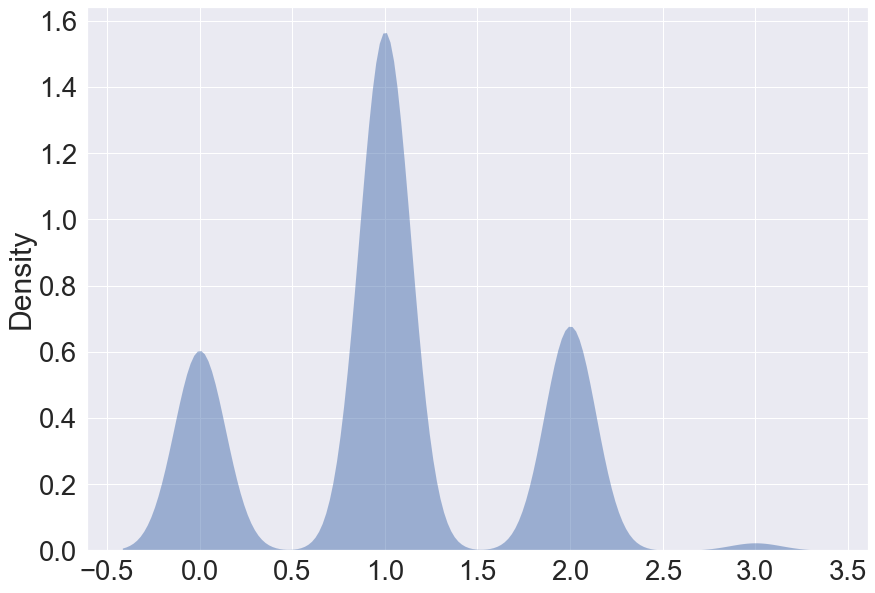

In [32]:
maj_emots = main_df.loc[:, emot_ans].astype(int)
sns.kdeplot(data=maj_emots.sum(axis=1).values, fill=True, common_norm=False, alpha=.5, linewidth=0)

Make one big dataframe with all of the congressional names and handles

In [33]:
# Name, Link, State, Party, Position, handle
df_117h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 117.csv')
df_117h['handle'] = df_117h['Link'].apply(lambda x: str(x).split('/')[-1].lower())
df_117h.rename(columns={'Party':'party', 'Name':'name', 'Position': 'position', 'State': 'state'}, inplace=True)
df_117h = df_117h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# first_name, last_name, party, state, handle, position
df_116h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 116.csv')
df_116h['handle'] = df_116h['twitter_handle'].apply(lambda x: str(x).lower())
df_116h['name'] = df_116h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_116h = df_116h.loc[:,['name', 'handle', 'state', 'party', 'position']]


# user_id, label, interval, dw_nominate, inferred_party, party, first_name, last_name, state, handle, Position
df_115h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 115.csv')
df_115h['handle'] = df_115h['twitter_account'].apply(lambda x: x.lower())
df_115h.rename(columns={'Position': 'position'}, inplace=True)
df_115h['name'] = df_115h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_115h = df_115h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# user_id, label, interval, dw_nominate, inferred_party, party, first_name, last_name, state, handle, Position
df_114h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 114.csv')
df_114h['handle'] = df_114h['twitter_account'].apply(lambda x: x.lower())
df_114h.rename(columns={'Position': 'position'}, inplace=True)
df_114h['name'] = df_114h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_114h = df_114h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# user_id, label, interval, dw_nominate, inferred_party, party, first_name, last_name, state, handle, Position
df_113h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 113.csv')
df_113h['handle'] = df_113h['twitter_account'].apply(lambda x: x.lower())
df_113h.rename(columns={'Position': 'position'}, inplace=True)
df_113h['name'] = df_113h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_113h = df_113h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# user_id, label, interval, dw_nominate, inferred_party, party, first_name, last_name, state, handle, Position
df_112h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 112.csv')
df_112h['handle'] = df_112h['twitter_account'].apply(lambda x: x.lower())
df_112h.rename(columns={'Position': 'position'}, inplace=True)
df_112h['name'] = df_112h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_112h = df_112h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# first_name, last_name, party, state, handle, position
df_111h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 111.csv')
df_111h['handle'] = df_111h['twitter_handle'].apply(lambda x: str(x).lower())
df_111h['name'] = df_111h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_111h = df_111h.loc[:,['name', 'handle', 'state', 'party', 'position']]

# first_name, last_name, party, state, handle, position
df_110h = pd.read_csv('../../lib-data/congressional-tweets-main/twitter-handles/Congress Twitter Handles - 110.csv')
df_110h['handle'] = df_110h['twitter_handle'].apply(lambda x: str(x).lower())
df_110h['name'] = df_110h.apply(lambda row: row['last_name'] + ', ' + row['first_name'], axis=1)
df_110h = df_110h.loc[:,['name', 'handle', 'state', 'party', 'position']]

df_h = pd.concat([df_117h, df_116h, df_115h, df_114h, df_113h, df_112h, df_111h, df_110h])
df_h.drop_duplicates(subset=['handle'], inplace=True)
df_h.set_index('handle', inplace=True)

In [34]:
def inoutgroup(x):
    handle_sp = x['username']
    handle_rf = x['mentname']
    
    if df_h.loc[handle_sp]['party'] != df_h.loc[handle_rf]['party']:
        return -1
    else:
        return 1
    
main_df['group'] = main_df.apply(lambda x: inoutgroup(x), axis=1)
main_df['party'] = main_df['username'].apply(lambda x: df_h.loc[x]['party'])

In [35]:
main_df.head()

,TweetId,tweet,username,mentname,Date,Predom,Feeling,Behavior,Admiration,Admiration_Int,Anger,Anger_Int,Disgust,Disgust_Int,Fear,Fear_Int,Interest,Interest_Int,Joy,Joy_Int,Sadness,Sadness_Int,Surprise,Surprise_Int,group,party
0,1001885064974790657,Admire @OfficialCBC Chairman @reprichmond's moral voice on issues of racism and restorative justice. He is a real leader for our nation and Congress.,reprokhanna,reprichmond,2018-05-30,predom,warm,app,True,3.000000,False,2.0,False,2.000000,False,2.0,False,2.333333,False,2.000000,False,2.0,False,2.0,1,D
1,1002970603165536258,It was wonderful to celebrate the 150th anniversary of Washington’s Pilotage Act this week with @pattymurray and this fantastic group in Port Townsend.,senatorcantwell,pattymurray,2018-06-02,predom,warm,app,False,2.000000,False,2.0,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D
2,1003713413292462082,"I’m proud to support legislation Senator @timkaine introduced to protect children if they are separated from their parents, and I’m going to continue looking at what else we can to do end the Trump Administration's deeply wrong policy.",pattymurray,timkaine,2018-06-04,predom,warm,app,False,2.333333,False,2.0,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D
3,1004419010333691904,"During #ImmigrantHeritageMonth, let’s remember the numerous contributions those “yearning to breathe free” have made to our nation, and do the people’s work by voting on bipartisan immigration reform measures. No more excuses, @speakerryan. #CelebrateImmigrants!",repdelbene,speakerryan,2018-06-06,predom,cold,disapp,False,2.000000,True,2.0,False,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,D
4,1004433631950065664,Thank you @senatorleahy. The Administration is choosing to implement an inhuman policy that separates migrant children from their parents. It must end now!,senbobcasey,senatorleahy,2018-06-06,predom,warm,app,True,2.000000,False,2.0,False,2.000000,False,2.0,False,2.000000,True,1.666667,False,2.0,False,2.0,1,D


In [36]:
Counter(main_df['group'])

Counter({1: 1516, -1: 1517})

In [37]:
main_df[emot_ans].values[0].sum()

1

In [38]:
main_df['None'] = main_df.apply(lambda x: True if x[emot_ans].values.sum()==0 else False, axis=1)
Counter(main_df['None'].values)

Counter({False: 2395, True: 638})

###  emotion distribution

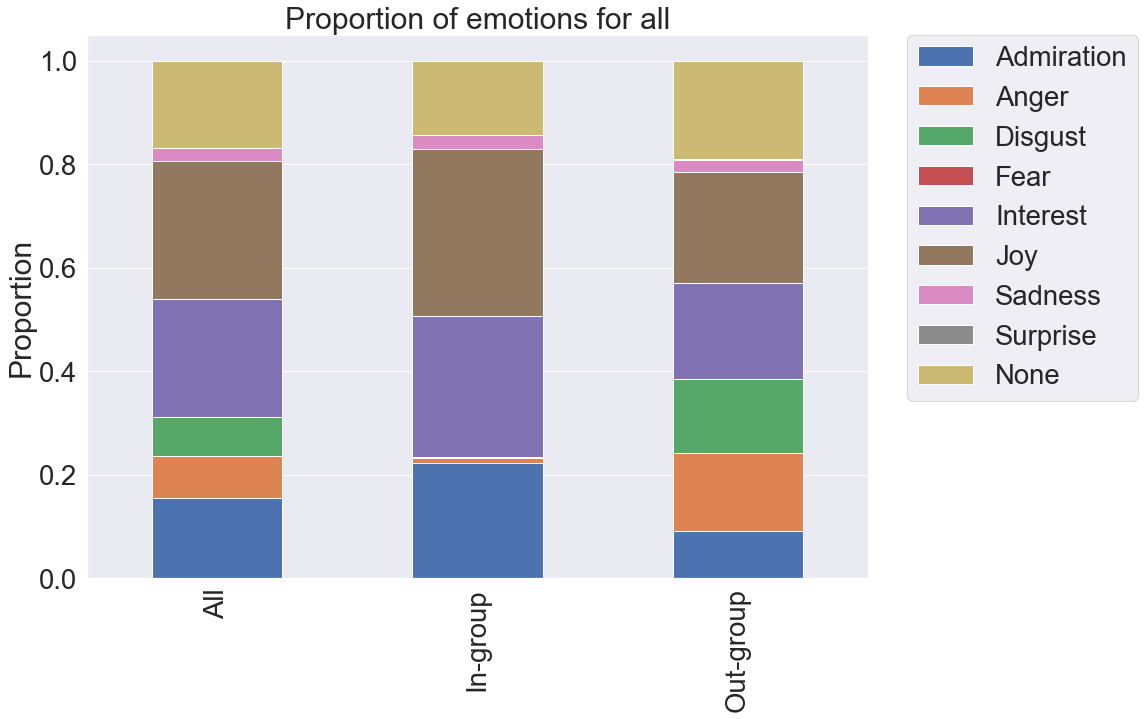

In [39]:
emot_ans_none = emot_ans + ['None']
x_labels = ['All', 'In-group', 'Out-group']

maj_emots_all = main_df.loc[:, emot_ans_none].astype(int)
emot_dist_all = maj_emots_all.sum().to_dict()
data_all = [emot_dist_all[a] for a in emot_ans_none]


maj_emots_in = main_df[main_df['group']==1].loc[:, emot_ans_none].astype(int)
emot_dist_in = maj_emots_in.sum().to_dict()
data_in = [emot_dist_in[a] for a in emot_ans_none]

maj_emots_out = main_df[main_df['group']==-1].loc[:, emot_ans_none].astype(int)
emot_dist_out = maj_emots_out.sum().to_dict()
data_out = [emot_dist_out[a] for a in emot_ans_none]

emprop = pd.DataFrame({'All': data_all, 'In-group': data_in, 'Out-group': data_out}).T
emprop.columns = emot_ans_none
emprop=emprop.div(emprop.sum(axis=1), axis=0)

# create stacked bar chart
fig=emprop.plot(kind='bar', stacked=True)
fig.grid(axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# labels for x & y axis
# plt.xlabel('Type')
plt.ylabel('Proportion')
 
# title of plot
plt.title('Proportion of emotions for all')
plt.show()

In [40]:
np.round(emprop,3)

,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise,None
All,0.155,0.082,0.074,0.000,0.229,0.267,0.025,0.000,0.168
In-group,0.222,0.010,0.003,0.000,0.272,0.322,0.026,0.000,0.145
Out-group,0.091,0.151,0.142,0.001,0.186,0.214,0.024,0.001,0.191


### Republican emotions

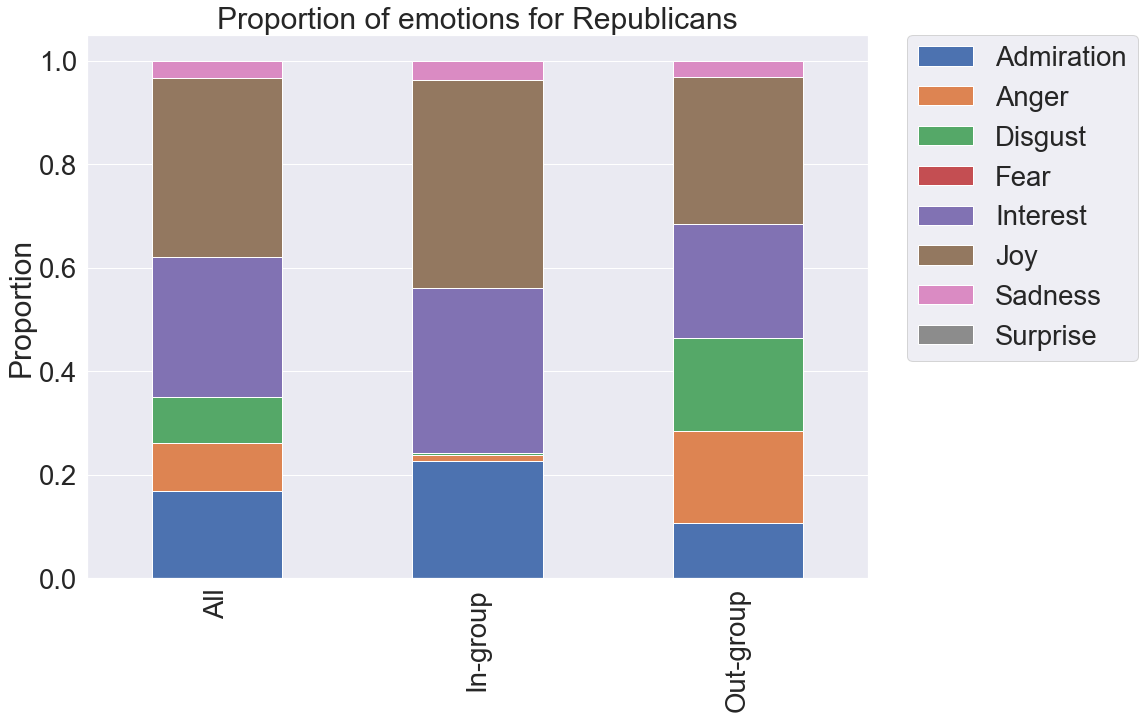

In [41]:
maj_emots_all = main_df[main_df['party']=='R'].loc[:, emot_ans].astype(int)
emot_dist_all = maj_emots_all.sum().to_dict()
data_all = [emot_dist_all[a] for a in emot_ans]


maj_emots_in = main_df[(main_df['party']=='R') & (main_df['group']==1)].loc[:, emot_ans].astype(int)
emot_dist_in = maj_emots_in.sum().to_dict()
data_in = [emot_dist_in[a] for a in emot_ans]

maj_emots_out = main_df[(main_df['party']=='R') & (main_df['group']==-1)].loc[:, emot_ans].astype(int)
emot_dist_out = maj_emots_out.sum().to_dict()
data_out = [emot_dist_out[a] for a in emot_ans]

emprop = pd.DataFrame({'All': data_all, 'In-group': data_in, 'Out-group': data_out}).T
emprop.columns = emot_ans
emprop=emprop.div(emprop.sum(axis=1), axis=0)

# create stacked bar chart
fig=emprop.plot(kind='bar', stacked=True)
fig.grid(axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# labels for x & y axis
# plt.xlabel('Type')
plt.ylabel('Proportion')
 
# title of plot
plt.title('Proportion of emotions for Republicans')
plt.show()

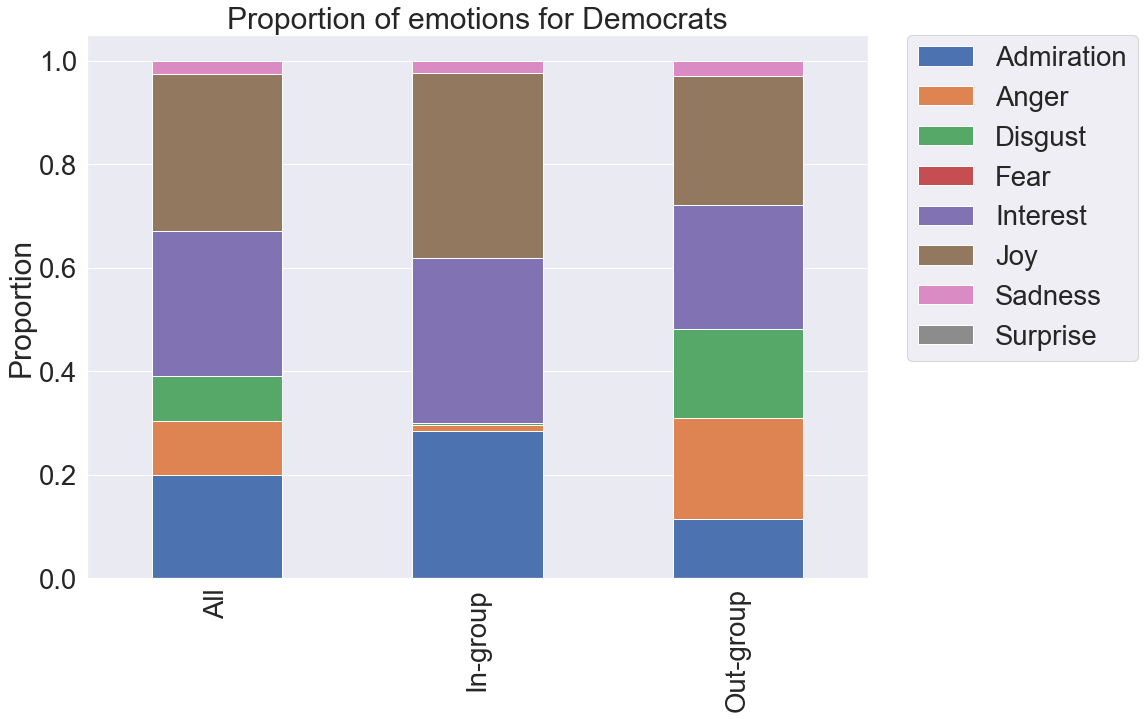

In [42]:
maj_emots_all = main_df[main_df['party']=='D'].loc[:, emot_ans].astype(int)
emot_dist_all = maj_emots_all.sum().to_dict()
data_all = [emot_dist_all[a] for a in emot_ans]


maj_emots_in = main_df[(main_df['party']=='D') & (main_df['group']==1)].loc[:, emot_ans].astype(int)
emot_dist_in = maj_emots_in.sum().to_dict()
data_in = [emot_dist_in[a] for a in emot_ans]

maj_emots_out = main_df[(main_df['party']=='D') & (main_df['group']==-1)].loc[:, emot_ans].astype(int)
emot_dist_out = maj_emots_out.sum().to_dict()
data_out = [emot_dist_out[a] for a in emot_ans]

emprop = pd.DataFrame({'All': data_all, 'In-group': data_in, 'Out-group': data_out}).T
emprop.columns = emot_ans
emprop=emprop.div(emprop.sum(axis=1), axis=0)

# create stacked bar chart
fig=emprop.plot(kind='bar', stacked=True)
fig.grid(axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# labels for x & y axis
# plt.xlabel('Type')
plt.ylabel('Proportion')
 
# title of plot
plt.title('Proportion of emotions for Democrats')
plt.show()

In [43]:
ann_df['username'].unique().shape

(554,)

In [44]:
ann_df['mentname'].unique().shape

(549,)

In [45]:
Counter(ann_df['username']).most_common(10)

[('senatorsinema', 159),
 ('stevescalise', 102),
 ('chrismurphyct', 90),
 ('repdankildee', 75),
 ('senrobportman', 69),
 ('roslehtinen', 69),
 ('senatorheitkamp', 69),
 ('repdonbeyer', 66),
 ('repmarkpocan', 63),
 ('lisamurkowski', 63)]

In [46]:
Counter(ann_df['mentname']).most_common(10)

[('speakerryan', 450),
 ('speakerpelosi', 342),
 ('speakerboehner', 294),
 ('stevescalise', 162),
 ('gopleader', 159),
 ('senatorreid', 138),
 ('repjohnlewis', 135),
 ('senjohnmccain', 123),
 ('chuckgrassley', 102),
 ('johncornyn', 81)]

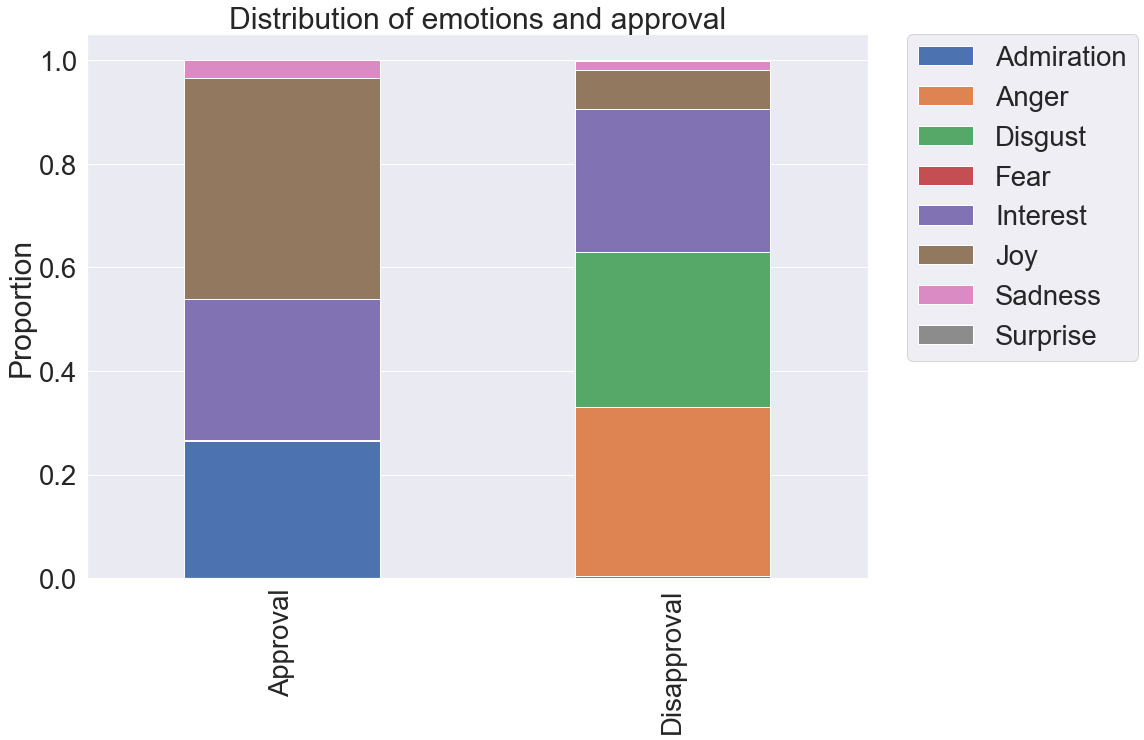

In [47]:
maj_emots_all = main_df[(main_df['Behavior']=='app')].loc[:, emot_ans].astype(int)
emot_dist_all = maj_emots_all.sum().to_dict()
data_all = [emot_dist_all[a] for a in emot_ans]


maj_emots_in = main_df[~(main_df['Behavior']=='app')].loc[:, emot_ans].astype(int)
emot_dist_in = maj_emots_in.sum().to_dict()
data_in = [emot_dist_in[a] for a in emot_ans]

emprop = pd.DataFrame({'Approval': data_all, 'Disapproval': data_in}).T
emprop.columns = emot_ans
emprop=emprop.div(emprop.sum(axis=1), axis=0)

# create stacked bar chart
fig=emprop.plot(kind='bar', stacked=True)
fig.grid(axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# labels for x & y axis
# plt.xlabel('Type')
plt.ylabel('Proportion')
 
# title of plot
plt.title('Distribution of emotions and approval')
plt.show()

In [48]:
ann_df.Date.min()

Timestamp('2010-06-17 00:00:00')

In [49]:
ann_df.Date.max()

Timestamp('2021-05-28 00:00:00')

In [50]:
done_ids = ann_df['TweetId'].unique().tolist()
with open('../done_ids.txt', 'w') as f:
    for a in done_ids:
        f.write(a + "\n")

In [51]:
ann_df.shape

(9099, 27)

In [52]:
ann_df['WorkerId'].unique()

array(['A2V66KLFVJTLKC', 'A32W24TWSWXW', 'A345TDMHP3DQ3G',
       'A3P9TM5PRYBH90', 'A320QA9HJFUOZO', 'A1PHTNZ62338BP'], dtype=object)

In [53]:
ann_df.shape

(9099, 27)

In [54]:
# main_df.to_csv('../../maj_df.tsv', sep='\t', index=False)

In [55]:
Counter([x.year for x in main_df.Date.tolist()])

Counter({2018: 366,
         2019: 369,
         2011: 4,
         2020: 349,
         2021: 129,
         2010: 2,
         2012: 6,
         2013: 320,
         2014: 329,
         2015: 352,
         2016: 371,
         2017: 436})

In [56]:
main_df.shape

(3033, 27)

In [57]:
main_df

,TweetId,tweet,username,mentname,Date,Predom,Feeling,Behavior,Admiration,Admiration_Int,Anger,Anger_Int,Disgust,Disgust_Int,Fear,Fear_Int,Interest,Interest_Int,Joy,Joy_Int,Sadness,Sadness_Int,Surprise,Surprise_Int,group,party,None
0,1001885064974790657,Admire @OfficialCBC Chairman @reprichmond's moral voice on issues of racism and restorative justice. He is a real leader for our nation and Congress.,reprokhanna,reprichmond,2018-05-30,predom,warm,app,True,3.000000,False,2.000000,False,2.000000,False,2.0,False,2.333333,False,2.000000,False,2.0,False,2.0,1,D,False
1,1002970603165536258,It was wonderful to celebrate the 150th anniversary of Washington’s Pilotage Act this week with @pattymurray and this fantastic group in Port Townsend.,senatorcantwell,pattymurray,2018-06-02,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D,False
2,1003713413292462082,"I’m proud to support legislation Senator @timkaine introduced to protect children if they are separated from their parents, and I’m going to continue looking at what else we can to do end the Trump Administration's deeply wrong policy.",pattymurray,timkaine,2018-06-04,predom,warm,app,False,2.333333,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D,False
3,1004419010333691904,"During #ImmigrantHeritageMonth, let’s remember the numerous contributions those “yearning to breathe free” have made to our nation, and do the people’s work by voting on bipartisan immigration reform measures. No more excuses, @speakerryan. #CelebrateImmigrants!",repdelbene,speakerryan,2018-06-06,predom,cold,disapp,False,2.000000,True,2.000000,False,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,D,False
4,1004433631950065664,Thank you @senatorleahy. The Administration is choosing to implement an inhuman policy that separates migrant children from their parents. It must end now!,senbobcasey,senatorleahy,2018-06-06,predom,warm,app,True,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,1.666667,False,2.0,False,2.0,1,D,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,999245047202811904,.@stevekingia should keep his eyes and “ears” on the corn in Iowa and leave Mayor Schaaf to continue ably serving her Oakland constituents.,repspeier,stevekingia,2018-05-23,predom,cold,disapp,False,2.000000,True,2.333333,True,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,D,False
3029,999289718683721728,"We’ve lost 630,000 Americans to overdoses since 2000. We're in the midst of an #OpioidEpidemic. The House will soon consider more than 60 bills to combat this epidemic because we can’t let opioids continue to ravage our communities. More from @gopleader:",speakerryan,gopleader,2018-05-23,predom,neutral,dunno,False,2.000000,False,2.000000,False,2.000000,False,2.0,True,2.333333,False,2.000000,False,2.0,False,2.0,1,R,False
3030,999329645316247552,The House approved an amendment to the National Defense Authorization Act that I sponsored along with @gracenapolitano supporting the National Guard Youth Challenge program. Read more here:,kencalvert,gracenapolitano,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,R,True
3031,999381351634743299,Led a letter to President Trump with @mikekellypa and 78 other members to ensure the government protects faith-based organizations that provide child welfare services from losing federal funding because of their religious faith.,senatorenzi,mikekellypa,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,1.666667,False,2.0,False,2.0,1,R,True


In [58]:
def train_valid_test():
    t = random.random()
    if t < 0.8:
        return 'train'
    else:
        h = random.random()
        if h < 0.5:
            return 'dev'
        else:
            return 'test'

main_df['Split'] = main_df.apply(lambda x: train_valid_test(), axis=1)

In [59]:
Counter(main_df['Split'])

Counter({'train': 2402, 'test': 325, 'dev': 306})

In [60]:
# main_df.to_csv('../../maj_df_split.tsv', sep='\t', index=False)

In [61]:
main_df['year'] = main_df['Date'].apply(lambda x: x.year)

## Emotions annotated over time

How do democrats show emotions over time? Depending on who the president is and who has control over house/senate

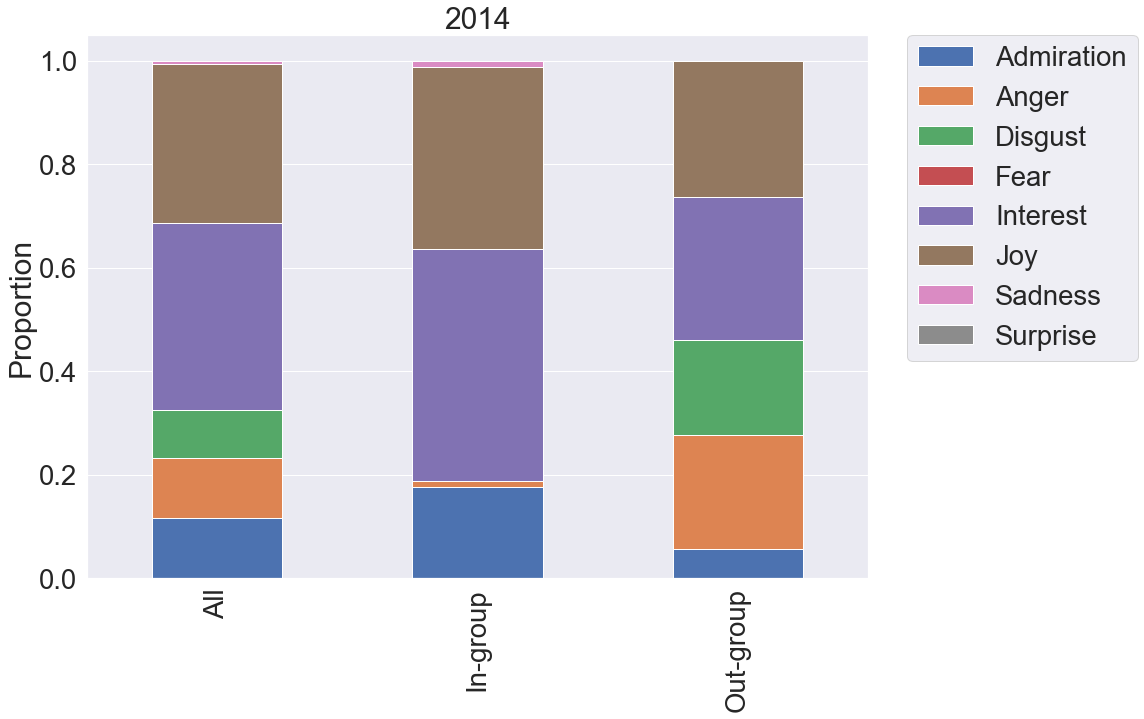

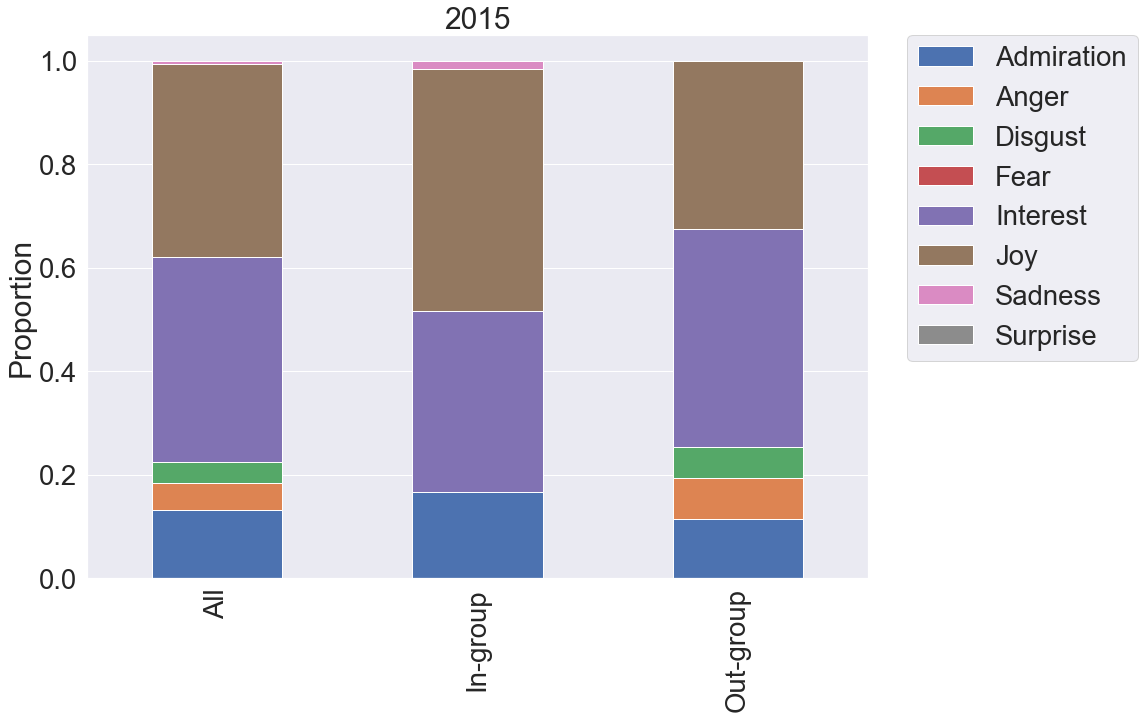

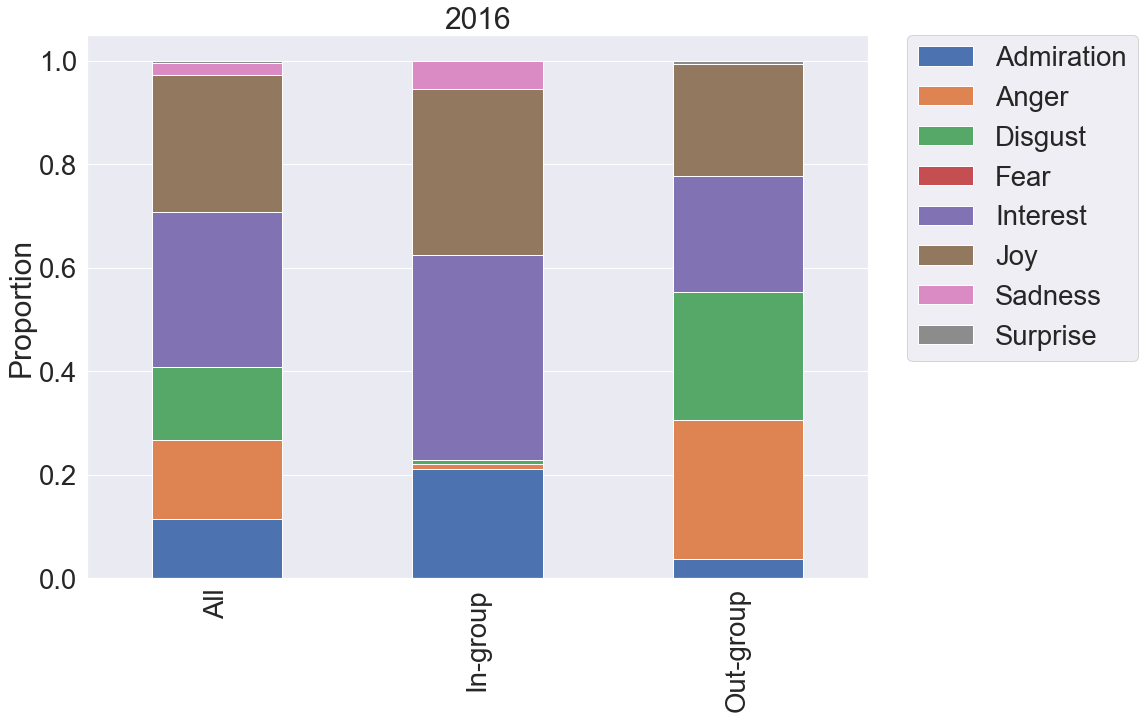

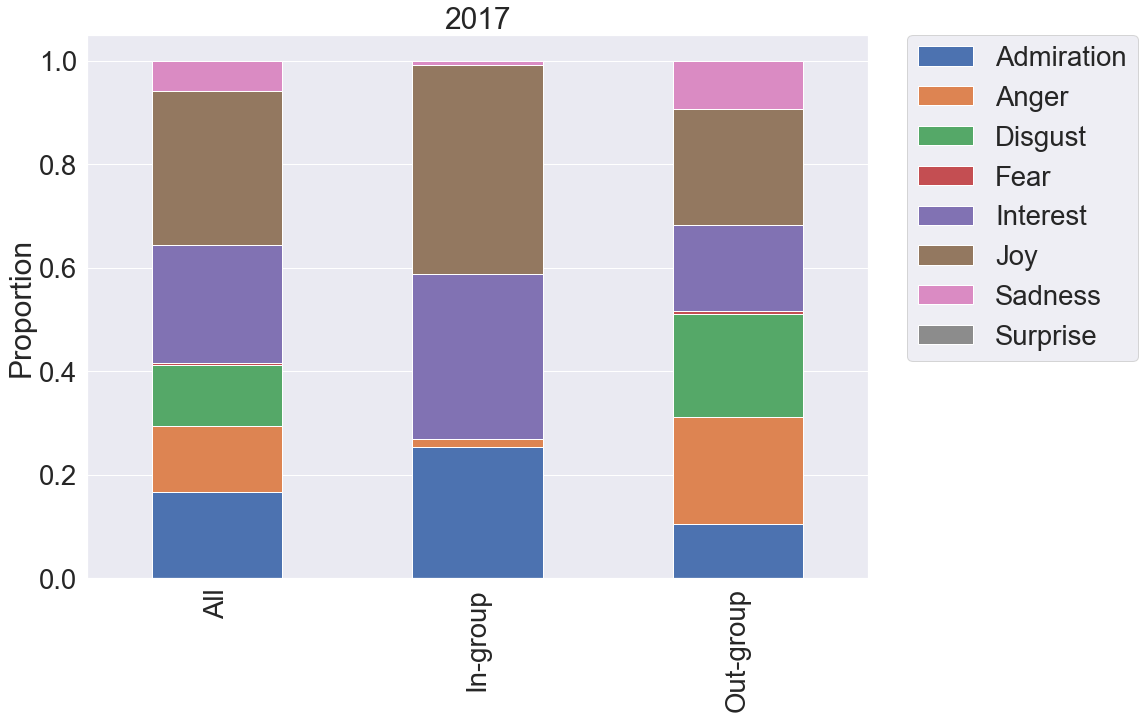

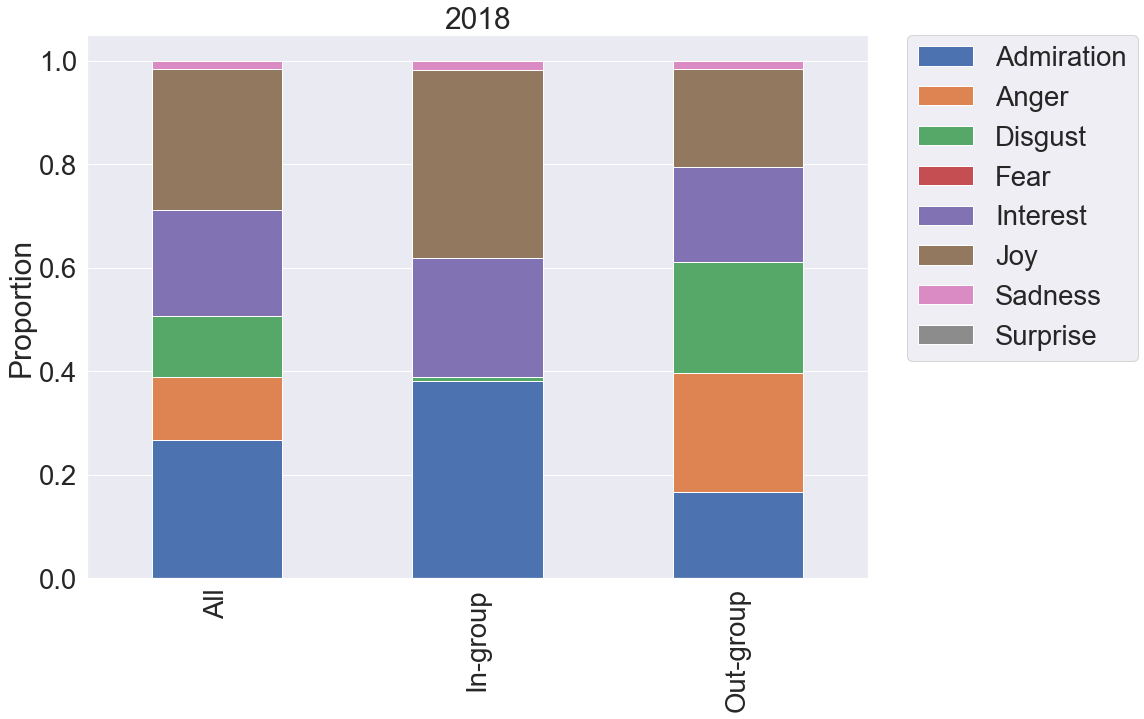

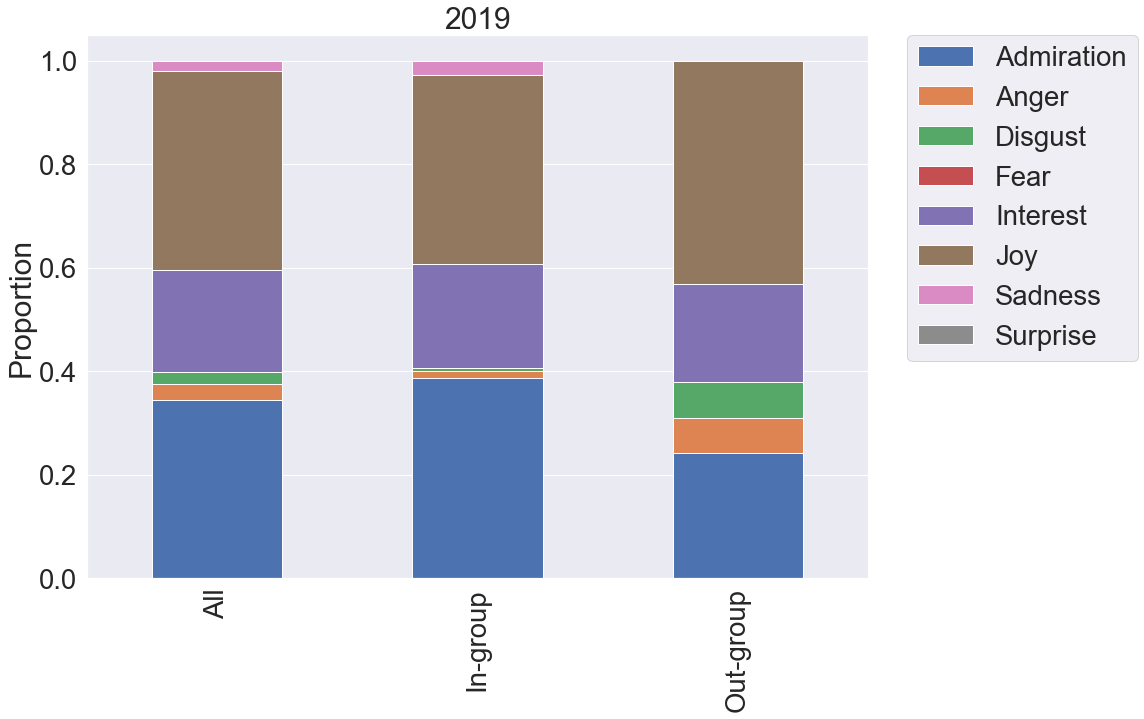

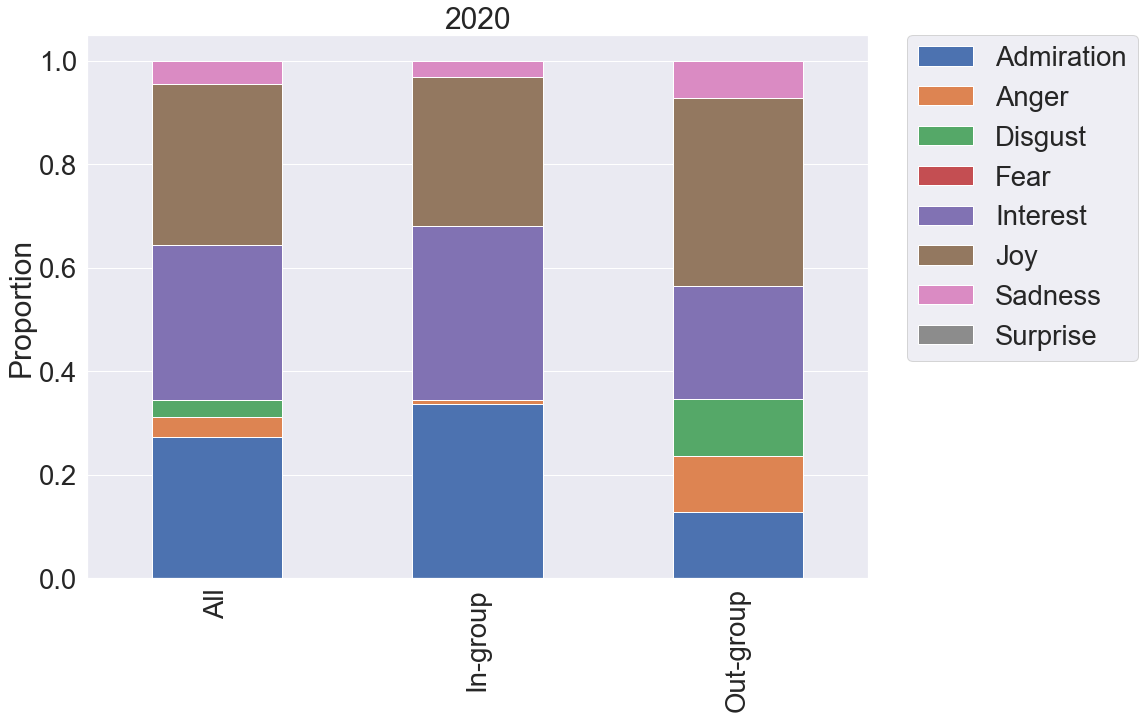

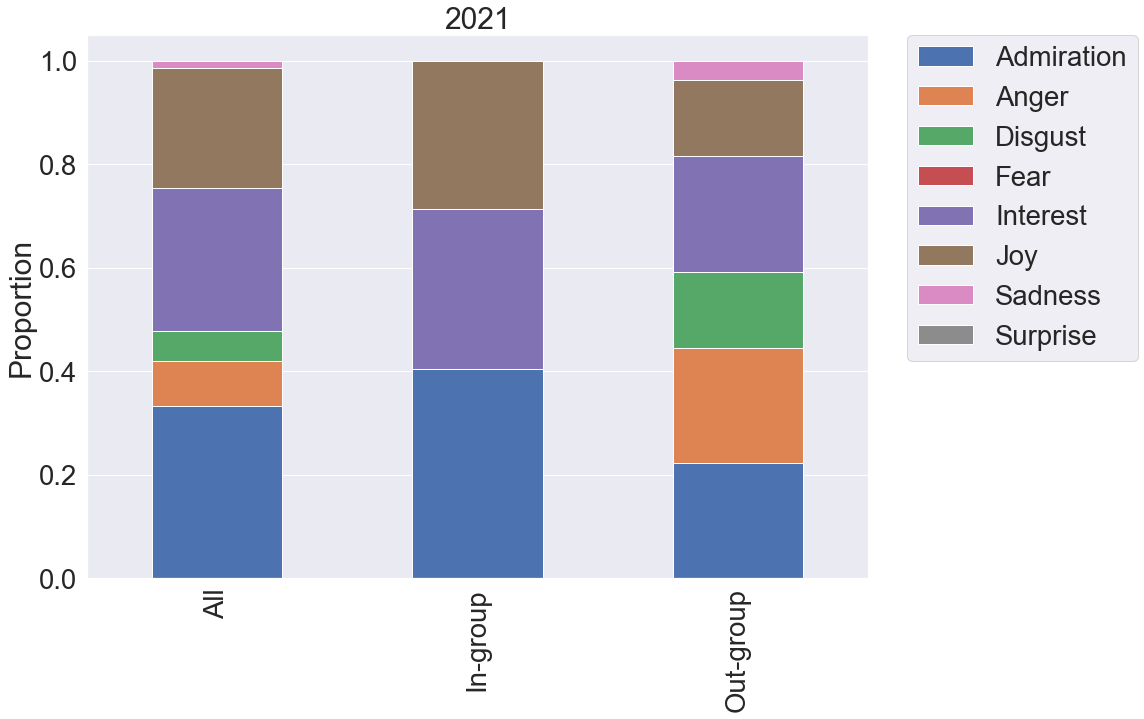

In [62]:
for year in range(2014, 2022):
    maj_emots_all = main_df[(main_df['party']=='D') & (main_df['year']==year)].loc[:, emot_ans].astype(int)
    emot_dist_all = maj_emots_all.sum().to_dict()
    data_all = [emot_dist_all[a] for a in emot_ans]

    maj_emots_in = main_df[(main_df['party']=='D') & (main_df['group']==1) & (main_df['year']==year)].loc[:, emot_ans].astype(int)
    emot_dist_in = maj_emots_in.sum().to_dict()
    data_in = [emot_dist_in[a] for a in emot_ans]

    maj_emots_out = main_df[(main_df['party']=='D') & (main_df['group']==-1) & (main_df['year']==year)].loc[:, emot_ans].astype(int)
    emot_dist_out = maj_emots_out.sum().to_dict()
    data_out = [emot_dist_out[a] for a in emot_ans]

    emprop = pd.DataFrame({'All': data_all, 'In-group': data_in, 'Out-group': data_out}).T
    emprop.columns = emot_ans
    emprop=emprop.div(emprop.sum(axis=1), axis=0)

    # create stacked bar chart
    fig=emprop.plot(kind='bar', stacked=True)
#     for container in fig.containers:
#         fig.bar_label(container)
    fig.grid(axis='x')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # labels for x & y axis
    # plt.xlabel('Type')
    plt.ylabel('Proportion')

    # title of plot
    plt.title(str(year))
    plt.show()
    

In [63]:
main_df.shape

(3033, 29)

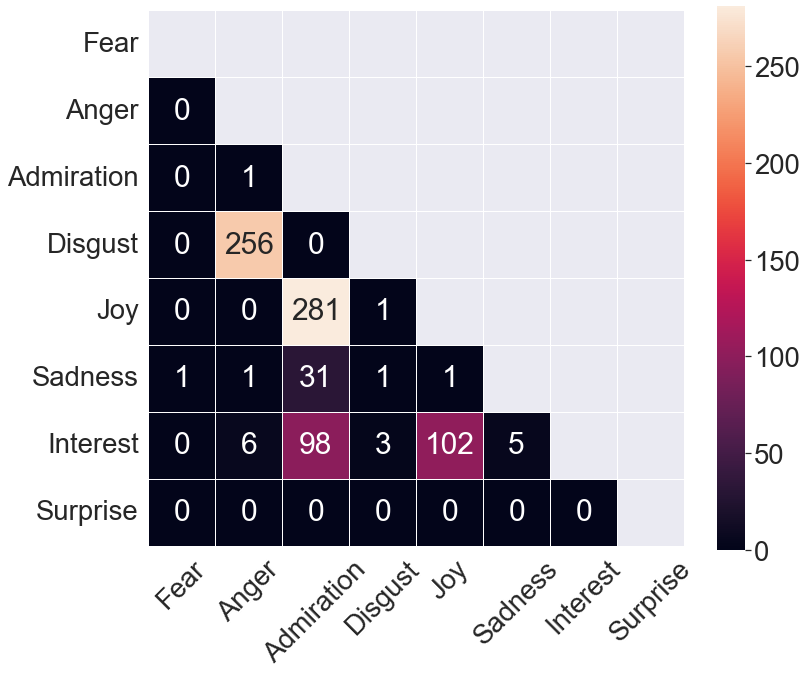

In [64]:
cooc_df = pd.DataFrame({x: {y: 0 for y in etc.keys()} for x in etc.keys()})
for _, row in main_df.iterrows():
    emots = frozenset([k for k in emot_ans if row[k]==True])    
    if emots == frozenset():
        emots = frozenset(['None'])
    task_data.append((w, tweet_id, emots))

    for x,y in combinations(emots, 2):
        cooc_df.loc[x, y] += 1
        cooc_df.loc[y, x] += 1
        
corr = np.corrcoef(np.random.randn(8, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(cooc_df, mask=mask, square=True, linewidths=.5, annot=True, fmt='g')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.savefig('heatmap.png', bbox_inches='tight', format='png', pad_inches=0)

In [65]:
main_df.shape

(3033, 29)

In [66]:
worker_ids = ann_df['WorkerId'].unique()
interrater_corr = {w: {e: 0 for e in emot_ans} for w in worker_ids}

In [67]:
from scipy.stats.mstats import spearmanr

In [68]:

for worker_id, worker_df in ann_df.groupby('WorkerId'):
    tweet_ids = worker_df['TweetId'].values
    remaining_df = ann_df[(ann_df['WorkerId']!=worker_id) & (ann_df['TweetId'].isin(tweet_ids))]
    
    for e in emot_ans:
        w_values = worker_df[e].values
        rem_values = remaining_df.groupby('TweetId').mean().reindex(tweet_ids)[e].values
        interrater_corr[worker_id][e] = spearmanr(w_values, rem_values, nan_policy='omit').correlation

In [69]:
interrater_corr

{'A2V66KLFVJTLKC': {'Admiration': 0.4601727076081087,
  'Anger': 0.5386392874655489,
  'Disgust': 0.2859800563567898,
  'Fear': 0.03038676593005133,
  'Interest': 0.2577076492652199,
  'Joy': 0.5248088100038587,
  'Sadness': 0.6953696512662878,
  'Surprise': 0.08340152083171856},
 'A32W24TWSWXW': {'Admiration': 0.4946805812085486,
  'Anger': 0.7321997283936963,
  'Disgust': 0.7275750150419072,
  'Fear': 0.04475185164733267,
  'Interest': 0.13564765980348192,
  'Joy': 0.6444290143804383,
  'Sadness': 0.7033101485021499,
  'Surprise': 0.08758535302314836},
 'A345TDMHP3DQ3G': {'Admiration': 0.438534004832398,
  'Anger': 0.6835836982442951,
  'Disgust': 0.7392156353355974,
  'Fear': -0.005444679240582484,
  'Interest': 0.2518664446831018,
  'Joy': 0.6415236068465863,
  'Sadness': 0.48894804136370484,
  'Surprise': 0.0},
 'A3P9TM5PRYBH90': {'Admiration': 0.4368987200519241,
  'Anger': 0.44870388017334056,
  'Disgust': 0.8428133759585702,
  'Fear': -0.0071637542157362765,
  'Interest': 0.402

In [70]:
worker_counts = Counter(ann_df['WorkerId'].values)

In [71]:
total = sum(worker_counts.values())
worker_ratios = {k:worker_counts[k]/total for k in worker_counts.keys()}

In [72]:
worker_ratios

{'A2V66KLFVJTLKC': 0.31816683151994724,
 'A32W24TWSWXW': 0.2966260028574569,
 'A345TDMHP3DQ3G': 0.33300362677217277,
 'A3P9TM5PRYBH90': 0.05154412572810199,
 'A320QA9HJFUOZO': 0.0003297065611605671,
 'A1PHTNZ62338BP': 0.0003297065611605671}

In [73]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [74]:
workers_of_interest = ['A2V66KLFVJTLKC', 'A32W24TWSWXW', 'A345TDMHP3DQ3G', 'A3P9TM5PRYBH90']

emot_inter = {e: [] for e in emot_ans}

for w in workers_of_interest:
    for e in emot_ans:
        emot_inter[e].append(interrater_corr[w][e])
        
worker_weights = [worker_ratios[x] for x in workers_of_interest]

In [75]:
emot_means = {e:0 for e in emot_ans}
emot_sd = {e:0 for e in emot_ans}

for e in emot_ans:
    mean, std = weighted_avg_and_std(emot_inter[e], worker_weights)
    emot_means[e] = mean
    emot_sd[e] = std

In [76]:
emot_means

{'Admiration': 0.46200444424874804,
 'Anger': 0.6397523952082769,
 'Disgust': 0.5968041435326563,
 'Fear': 0.02077397516083848,
 'Interest': 0.22699492903255766,
 'Joy': 0.6100995138103836,
 'Sadness': 0.6330151328402627,
 'Surprise': 0.05239431635982323}

In [77]:
emot_sd

{'Admiration': 0.023109806892661258,
 'Anger': 0.09118437678584292,
 'Disgust': 0.2138094923923706,
 'Fear': 0.02166553441871358,
 'Interest': 0.0676047633526869,
 'Joy': 0.06174482385585224,
 'Sadness': 0.10320311507959896,
 'Surprise': 0.041795385137157484}

In [78]:
emot_counts = {e:0 for e in emot_ans}
for e in emot_ans:
    count = ann_df[ann_df[e]==True].shape[0]
    emot_counts[e] = count

In [79]:
emot_all_inter = {'means': emot_means, 'std': emot_sd, 'counts':emot_counts}

In [80]:
df_inter = pd.DataFrame(emot_all_inter)
df_inter

,means,std,counts
Admiration,0.462004,0.023110,2101
Anger,0.639752,0.091184,961
Disgust,0.596804,0.213809,804
Fear,0.020774,0.021666,92
Interest,0.226995,0.067605,3110
Joy,0.610100,0.061745,3209
Sadness,0.633015,0.103203,296
Surprise,0.052394,0.041795,24


In [81]:
df_internew=df_inter.sort_values(by='counts', ascending=False)

In [82]:
df_internew

,means,std,counts
Joy,0.610100,0.061745,3209
Interest,0.226995,0.067605,3110
Admiration,0.462004,0.023110,2101
Anger,0.639752,0.091184,961
Disgust,0.596804,0.213809,804
Sadness,0.633015,0.103203,296
Fear,0.020774,0.021666,92
Surprise,0.052394,0.041795,24


In [83]:
df_internew['means'].max()

0.6397523952082769

/var/folders/_m/wlstm1qs7j5cld1vjcv6pl700000gn/T/ipykernel_31113/3859292719.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(sm)


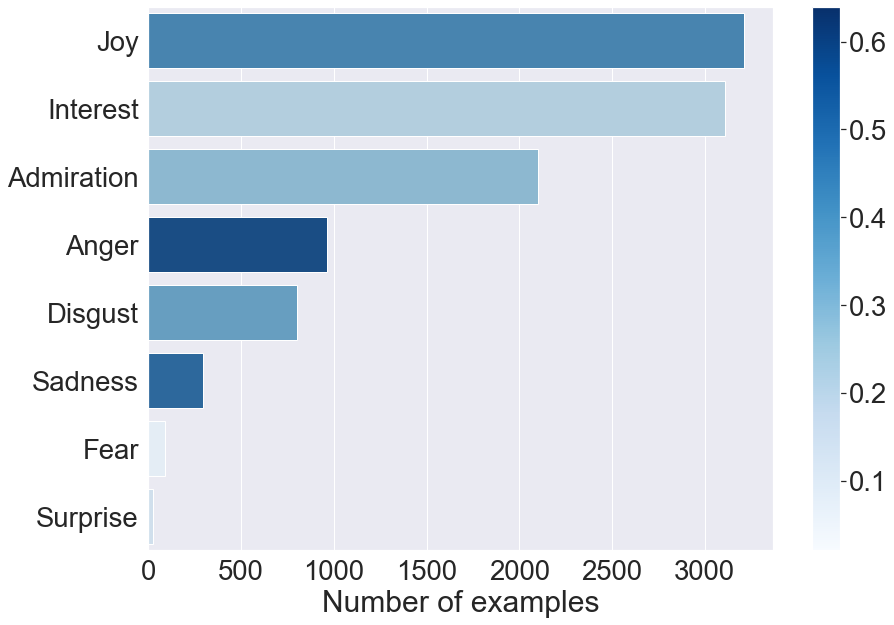

In [84]:
norm = plt.Normalize(df_internew['means'].min(), df_internew['means'].max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])


ax = sns.barplot(y=df_internew.index, hue='means', x='counts', xerr=df_internew['std'], data=df_internew, palette='Blues', dodge=False)

ax.set_xlabel('Number of examples')
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.savefig('interrater.png', bbox_inches='tight', format='png', pad_inches=0)

In [85]:
main_df[main_df['Disgust']==True]

,TweetId,tweet,username,mentname,Date,Predom,Feeling,Behavior,Admiration,Admiration_Int,Anger,Anger_Int,Disgust,Disgust_Int,Fear,Fear_Int,Interest,Interest_Int,Joy,Joy_Int,Sadness,Sadness_Int,Surprise,Surprise_Int,group,party,None,Split,year
14,1006988103393869824,"After 17 years, it’s past time to do our constitutional duty by debating and voting on the costs and consequences of #endlesswar. We owe it to our brave men & women in uniform. We can’t let @speakerryan succeed in silencing a war debate that Congress should have held years ago.",repbarbaralee,speakerryan,2018-06-13,predom,cold,disapp,False,2.0,True,2.666667,True,2.666667,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
20,1008378989801549825,It’s deeply troubling to see @gopleader leader pandering to the President and spreading a misleading smear against the Department of Justice. They claim to be the party of “law and order”- but not for their own President.,replowenthal,gopleader,2018-06-17,predom,cold,disapp,False,2.0,True,2.333333,True,2.000000,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
28,1010284012173053952,Those Republicans who wanted to help #DREAMers got played by their leadership. They gave up their leverage on the same promise that they would finally get a vote that @speakerryan has been breaking for a year.,repscottpeters,speakerryan,2018-06-22,predom,cold,disapp,False,2.0,True,2.333333,True,2.333333,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
49,1019350300694581250,"I urge Chairman @chuckgrassley to make good on his commitments & hold such hearings immediately, as I & others have repeatedly requested.",senblumenthal,chuckgrassley,2018-07-17,predom,cold,disapp,False,2.0,True,1.666667,True,1.666667,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
60,1023333182106689536,Here’s my statement regarding the refusal by @senjudiciary Chairman @chuckgrassley to request critical documents related to Supreme Court nominee #BrettKavanaugh’s work as a senior advisor to President George W. Bush⬇️,senwhitehouse,chuckgrassley,2018-07-28,predom,neutral,neutral,False,2.0,True,2.666667,True,2.666667,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,994672854250721281,"I see the problem here. @speakerryan is mistaking the super rich for all Americans. Middle class Americans will be happy for a tax bill weighed towards them as opposed to the #GOPTaxScam, which gave 80% of the benefits to the top 1%.",repjudychu,speakerryan,2018-05-10,predom,cold,disapp,False,2.0,True,2.333333,True,2.333333,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
3018,996076669776560128,".@speakerryan, nearly 9,000 low-income children and their mothers in my district receive healthcare through #CHIP. ANY cuts to this essential, life-saving program will cause undue harm to our communities. #BeBest and leave CHIP alone!",repdwightevans,speakerryan,2018-05-14,predom,cold,disapp,False,2.0,True,2.333333,True,2.333333,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
3021,996841915659276289,"The American people have made clear they want a free and open internet, without fast lanes and slow lanes. It’s time for Congress to listen. The Senate just voted to save #NetNeutrality. There is no excuse. @speakerryan must schedule a vote. Now.",repadamschiff,speakerryan,2018-05-16,predom,cold,disapp,False,2.0,True,2.333333,True,2.333333,False,2.0,False,2.0,False,2.0,False,2.0,False,2.0,-1,D,False,train,2018
3026,997487989692469248,Last night I signed the #QueenoftheHill discharge petition to force debate on four immigration bills. @speakerryan’s refusal to bring up a vote on DACA is shameful & cruel. We need to pass a long-term bipartisan solution to #ProtectDreamers.,repkathleenrice,speakerryan,2018-05-18,predom,cold,disapp,F

In [86]:
disgust_counter = Counter(main_df[main_df['Disgust']==True]['mentname'])
sum(disgust_counter.values())

281

In [87]:
disgust_counter

Counter({'speakerryan': 81,
         'gopleader': 11,
         'chuckgrassley': 2,
         'speakerpelosi': 65,
         'senwhitehouse': 1,
         'johncornyn': 1,
         'repjerrynadler': 3,
         'repadamschiff': 14,
         'ilhan': 2,
         'repdevinnunes': 1,
         'lindseygrahamsc': 1,
         'senschumer': 4,
         'senwarren': 1,
         'repaoc': 2,
         'sentomcotton': 1,
         'senblumenthal': 1,
         'senronjohnson': 1,
         'senjohnkennedy': 1,
         'repswalwell': 1,
         'repmaxinewaters': 1,
         'senatorburr': 1,
         'speakerboehner': 33,
         'senatorreid': 24,
         'sentoomey': 1,
         'darrellissa': 2,
         'sentedcruz': 1,
         'reptedyoho': 1,
         'waxmanclimate': 1,
         'jackkingston': 1,
         'repbera': 1,
         'senthomtillis': 1,
         'reptimwalz': 1,
         'stevekingia': 3,
         'chrismurphyct': 1,
         'reppittenger': 1,
         'reptomprice': 4,
        

In [88]:
disgust_counter['speakerryan'] + disgust_counter['speakerpelosi'] + disgust_counter['speakerboehner']

179

In [89]:
anger_counter = Counter(main_df[main_df['Anger']==True]['mentname'])
sum(anger_counter.values())

311

In [90]:
anger_counter

Counter({'speakerryan': 86,
         'gopleader': 14,
         'chuckgrassley': 3,
         'speakerpelosi': 69,
         'senwhitehouse': 1,
         'johncornyn': 1,
         'repadamschiff': 13,
         'ilhan': 2,
         'repblumenauer': 1,
         'repdevinnunes': 1,
         'lindseygrahamsc': 1,
         'repstefanik': 1,
         'repjerrynadler': 1,
         'senschumer': 4,
         'senwarren': 2,
         'repaoc': 2,
         'repjayapal': 1,
         'repgarretgraves': 1,
         'senblumenthal': 1,
         'senronjohnson': 1,
         'senjohnkennedy': 1,
         'repkinzinger': 1,
         'speakerboehner': 45,
         'senatorburr': 1,
         'sentoomey': 1,
         'senatorboxer': 1,
         'darrellissa': 2,
         'sentedcruz': 2,
         'senatorreid': 25,
         'nikiinthehouse': 1,
         'reptedyoho': 1,
         'waxmanclimate': 1,
         'pattymurray': 1,
         'jackkingston': 1,
         'repmarciafudge': 1,
         'repjimrenacci': 1

In [91]:
anger_counter['speakerryan'] + anger_counter['speakerpelosi'] + anger_counter['speakerboehner']

200

In [92]:
all_counter = Counter(main_df['mentname'].values)

In [93]:
all_counter['speakerryan'] + all_counter['speakerpelosi'] + all_counter['speakerboehner']

362

In [94]:
sum(all_counter.values())

3033

In [95]:
Counter(ann_df['No_Emotion'].values)

Counter({False: 8021, True: 1078})

In [96]:
arr=main_df.loc[:,emot_ans].astype(int).values

### Number of tweets with no emotions associated with them

In [97]:
noemot_tweets = 0

for i in range(3033):
    x = arr[i]
    if 1 not in x:
        noemot_tweets += 1
noemot_tweets

638

In [98]:
1 not in arr[33]

False

In [99]:
emot_ans

['Admiration',
 'Anger',
 'Disgust',
 'Fear',
 'Interest',
 'Joy',
 'Sadness',
 'Surprise']

In [100]:
main_df[(main_df['Sadness']==True) & (main_df['group']==1)][['group', 'tweet', 'username'] + emot_ans]

,group,tweet,username,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise
74,1,Continuing to keep @senjohnmccain and his family in our prayers.,senatorrounds,False,False,False,False,False,False,True,False
180,1,Paul has been an exceptional Speaker. We both came to Congress in 1999 and I have enjoyed a great working relationship with him since we first met. @speakerryan will be truly missed.,congmikesimpson,True,False,False,False,False,False,True,False
227,1,It was a great honor to serve with John Dingell. I learned so much from him and continue to learn from his wife @repdebdingell who serves with such distinction. I’m so sorry to learn of his passing and ask everyone to keep the Dingell family in their prayers.,repderekkilmer,True,False,False,False,False,False,True,False
230,1,I was saddened tonight to hear of the passing of my colleague @repwalterjones. Congressman Jones made his principles clear to all and consistently voted his conscience. He represented his district with honor and my prayers are with his family.,reppaulmitchell,True,False,False,False,False,False,True,False
550,1,"Sending strength and love to @repdebdingell and her family. John was a titan of service and an example to us all - no tweet, even from the President, can take that legacy away. Debbie is grace, grit, and moral clarity personified. It's an honor to serve alongside her.",repharley,False,False,False,False,False,False,True,False
554,1,"Wishing my friend @repjohnlewis, a man who has more fight in him than anyone I know in Congress, continued strength and courage in his battle. A true American hero.",repjohnyarmuth,True,False,False,False,False,False,True,False
555,1,"John Lewis is a force to be reckoned with, and I know he will fight this diagnosis with the same fierce determination that he brings every single day. My prayers are with you, @repjohnlewis.",senatorbaldwin,True,False,False,False,False,False,True,False
558,1,"Deeply saddened to hear of the passing of former Congressman Mike Fitzpatrick, who tirelessly served Bucks County and the Commonwealth. My prayers are with his brother, @repbrianfitz, and the entire Fitzpatrick family during this difficult time.",greschenthaler,False,False,False,False,False,False,True,False
572,1,Very distressing news. Best wishes to your family from mine @repjerrynadler.,repdonbeyer,False,False,False,False,False,False,True,False
629,1,Praying for you @repdesaulnier ????,normajtorres,False,False,False,False,False,False,True,False


In [101]:
np.sum(main_df[main_df['Split']=='train'].loc[:,emot_ans].astype(int).values, axis=0)

array([467, 225, 206,   1, 701, 801,  72,   1])

In [102]:
emot_ans

['Admiration',
 'Anger',
 'Disgust',
 'Fear',
 'Interest',
 'Joy',
 'Sadness',
 'Surprise']

In [103]:
arr=main_df[main_df['Split']=='test'].loc[:,emot_ans].astype(int).values
noemot_tweets = 0

for i in range(arr.shape[0]):
    x = arr[i]
    if 1 not in x:
        noemot_tweets += 1
noemot_tweets

63

In [104]:
arr=main_df[main_df['Split']=='train'].loc[:,emot_ans].astype(int).values
noemot_tweets = 0

for i in range(arr.shape[0]):
    x = arr[i]
    if 1 not in x:
        noemot_tweets += 1
noemot_tweets

519

In [105]:
arr=main_df[main_df['Split']=='dev'].loc[:,emot_ans].astype(int).values
noemot_tweets = 0

for i in range(arr.shape[0]):
    x = arr[i]
    if 1 not in x:
        noemot_tweets += 1
noemot_tweets

56

In [106]:
Counter(main_df[main_df['Split']=='test']['group'])

Counter({1: 166, -1: 159})

In [107]:
Counter([x.year for x in main_df.Date.tolist()])

Counter({2018: 366,
         2019: 369,
         2011: 4,
         2020: 349,
         2021: 129,
         2010: 2,
         2012: 6,
         2013: 320,
         2014: 329,
         2015: 352,
         2016: 371,
         2017: 436})

In [108]:
main_df.columns

Index(['TweetId', 'tweet', 'username', 'mentname', 'Date', 'Predom', 'Feeling',
       'Behavior', 'Admiration', 'Admiration_Int', 'Anger', 'Anger_Int',
       'Disgust', 'Disgust_Int', 'Fear', 'Fear_Int', 'Interest',
       'Interest_Int', 'Joy', 'Joy_Int', 'Sadness', 'Sadness_Int', 'Surprise',
       'Surprise_Int', 'group', 'party', 'None', 'Split', 'year'],
      dtype='object')

In [109]:
main_df.loc[:,['Split', 'tweet', 'username', 'mentname', 'Date', 'group', 'party'] + emot_ans]

,Split,tweet,username,mentname,Date,group,party,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise
0,train,Admire @OfficialCBC Chairman @reprichmond's moral voice on issues of racism and restorative justice. He is a real leader for our nation and Congress.,reprokhanna,reprichmond,2018-05-30,1,D,True,False,False,False,False,False,False,False
1,test,It was wonderful to celebrate the 150th anniversary of Washington’s Pilotage Act this week with @pattymurray and this fantastic group in Port Townsend.,senatorcantwell,pattymurray,2018-06-02,1,D,False,False,False,False,False,True,False,False
2,train,"I’m proud to support legislation Senator @timkaine introduced to protect children if they are separated from their parents, and I’m going to continue looking at what else we can to do end the Trump Administration's deeply wrong policy.",pattymurray,timkaine,2018-06-04,1,D,False,False,False,False,False,True,False,False
3,train,"During #ImmigrantHeritageMonth, let’s remember the numerous contributions those “yearning to breathe free” have made to our nation, and do the people’s work by voting on bipartisan immigration reform measures. No more excuses, @speakerryan. #CelebrateImmigrants!",repdelbene,speakerryan,2018-06-06,-1,D,False,True,False,False,False,False,False,False
4,train,Thank you @senatorleahy. The Administration is choosing to implement an inhuman policy that separates migrant children from their parents. It must end now!,senbobcasey,senatorleahy,2018-06-06,1,D,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,train,.@stevekingia should keep his eyes and “ears” on the corn in Iowa and leave Mayor Schaaf to continue ably serving her Oakland constituents.,repspeier,stevekingia,2018-05-23,-1,D,False,True,True,False,False,False,False,False
3029,train,"We’ve lost 630,000 Americans to overdoses since 2000. We're in the midst of an #OpioidEpidemic. The House will soon consider more than 60 bills to combat this epidemic because we can’t let opioids continue to ravage our communities. More from @gopleader:",speakerryan,gopleader,2018-05-23,1,R,False,False,False,False,True,False,False,False
3030,train,The House approved an amendment to the National Defense Authorization Act that I sponsored along with @gracenapolitano supporting the National Guard Youth Challenge program. Read more here:,kencalvert,gracenapolitano,2018-05-23,-1,R,False,False,False,False,False,False,False,False
3031,test,Led a letter to President Trump with @mikekellypa and 78 other members to ensure the government protects faith-based organizations that provide child welfare services from losing federal funding because of their religious faith.,senatorenzi,mikekellypa,2018-05-23,1,R,False,False,False,False,False,False,False,False


In [110]:
main_df.loc[:,['Split', 'TweetId', 'username', 'mentname', 'Date', 'group', 'party'] + emot_ans].sort_values('Split').to_csv('data.tsv', sep='\t', index=False)

In [111]:
neutral_df = main_df.loc[:, ['group', 'party'] + emot_ans]
neutral_df['party'] = neutral_df['party'].apply(lambda x: 1 if x=='D' else 0)
neutral_df = neutral_df.astype(int)

In [112]:
neutral_df

,group,party,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise
0,1,1,1,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0
2,1,1,0,0,0,0,0,1,0,0
3,-1,1,0,1,0,0,0,0,0,0
4,1,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3028,-1,1,0,1,1,0,0,0,0,0
3029,1,0,0,0,0,0,1,0,0,0
3030,-1,0,0,0,0,0,0,0,0,0
3031,1,0,0,0,0,0,0,0,0,0


In [113]:
neutral_df[emot_ans].values[0].sum()

1

In [114]:
neutral_df['sumemot'] = neutral_df.apply(lambda x: x[emot_ans].values.sum(), axis=1)
neutral_df

,group,party,Admiration,Anger,Disgust,Fear,Interest,Joy,Sadness,Surprise,sumemot
0,1,1,1,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,1,0,0,1
2,1,1,0,0,0,0,0,1,0,0,1
3,-1,1,0,1,0,0,0,0,0,0,1
4,1,1,1,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
3028,-1,1,0,1,1,0,0,0,0,0,2
3029,1,0,0,0,0,0,1,0,0,0,1
3030,-1,0,0,0,0,0,0,0,0,0,0
3031,1,0,0,0,0,0,0,0,0,0,0


In [115]:
Counter(neutral_df[neutral_df['sumemot']==0]['group'].values)

Counter({-1: 369, 1: 269})

In [116]:
Counter(neutral_df[neutral_df['sumemot']==0]['party'].values)

Counter({1: 360, 0: 278})

[Text(0.5, 0, 'Fear'),
 Text(1.5, 0, 'Anger'),
 Text(2.5, 0, 'Admiration'),
 Text(3.5, 0, 'Disgust'),
 Text(4.5, 0, 'Joy'),
 Text(5.5, 0, 'Sadness'),
 Text(6.5, 0, 'Interest'),
 Text(7.5, 0, 'Surprise')]

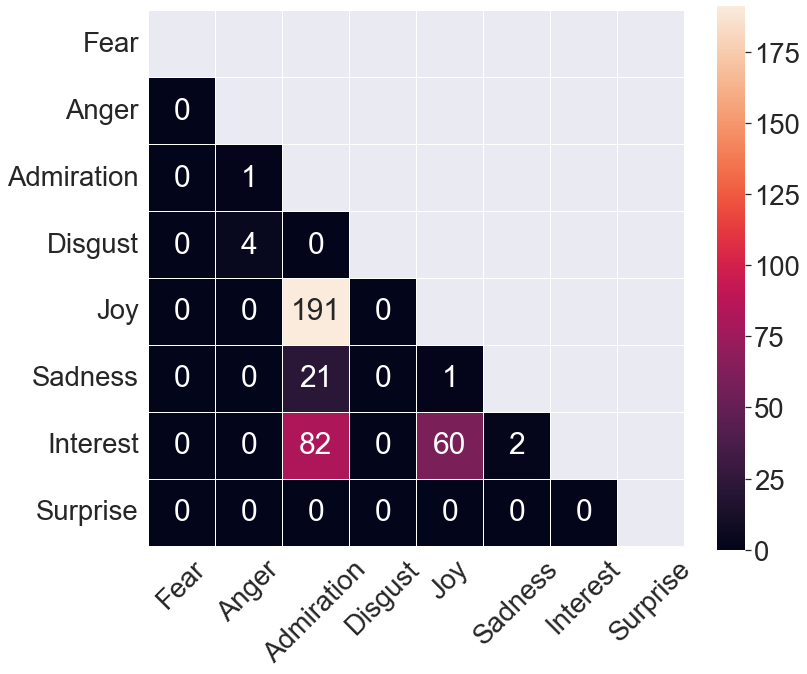

In [117]:
cooc_df = pd.DataFrame({x: {y: 0 for y in etc.keys()} for x in etc.keys()})
in_df = main_df[main_df['group']==1]
for _, row in in_df.iterrows():
    emots = frozenset([k for k in emot_ans if row[k]==True])    
    if emots == frozenset():
        emots = frozenset(['None'])
    task_data.append((w, tweet_id, emots))

    for x,y in combinations(emots, 2):
        cooc_df.loc[x, y] += 1
        cooc_df.loc[y, x] += 1
        
corr = np.corrcoef(np.random.randn(8, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(cooc_df, mask=mask, square=True, linewidths=.5, annot=True, fmt='g')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

[Text(0.5, 0, 'Fear'),
 Text(1.5, 0, 'Anger'),
 Text(2.5, 0, 'Admiration'),
 Text(3.5, 0, 'Disgust'),
 Text(4.5, 0, 'Joy'),
 Text(5.5, 0, 'Sadness'),
 Text(6.5, 0, 'Interest'),
 Text(7.5, 0, 'Surprise')]

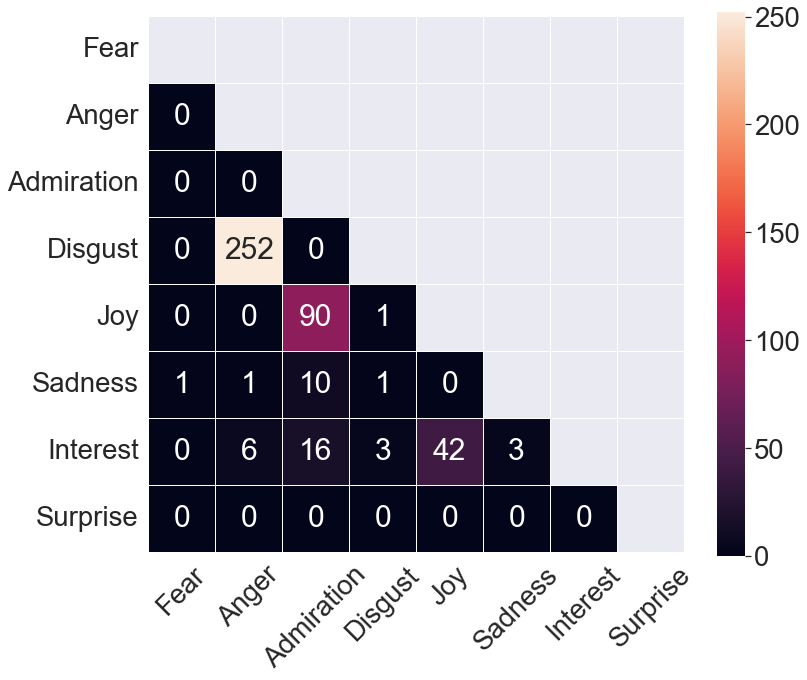

In [118]:
cooc_df = pd.DataFrame({x: {y: 0 for y in etc.keys()} for x in etc.keys()})
in_df = main_df[main_df['group']==-1]
for _, row in in_df.iterrows():
    emots = frozenset([k for k in emot_ans if row[k]==True])    
    if emots == frozenset():
        emots = frozenset(['None'])
    task_data.append((w, tweet_id, emots))

    for x,y in combinations(emots, 2):
        cooc_df.loc[x, y] += 1
        cooc_df.loc[y, x] += 1
        
corr = np.corrcoef(np.random.randn(8, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(cooc_df, mask=mask, square=True, linewidths=.5, annot=True, fmt='g')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [119]:
from scipy.stats import pearsonr
pearsonr(main_df['Anger'].values, main_df['Disgust'].values)

(0.8516350348975955, 0.0)

In [120]:
main_df[main_df['Disgust']==True]['mentname'].unique().shape

(45,)